# ADA 2018 -  Music, from 90's to Milenials

#### Andres Montero, Ariel Alba, Diego Iriarte




Have you ever wondered how music evolved in the last years? Today with the explosion of the internet, music Services as Apple Music, Spotify, Tidal and other apps and platforms; it has become easier to access, obtain and share music. This project aims to find the evolution of music since 2000's in terms of songs/genres/artists popularity and preferences, evaluate the key features of the songs, such as energy, valence and danceability. We aim to understand and show how and which was the most popular genre in the last years, the most popular songs, the most important artist and what were the trends of the key features of those hits. 

For this purpose, we'll work with two datasets:

* FMA: A Dataset For Music Analysis
* Our crawled dataset created using Spotify and LastFM API



In [1]:
% matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import reverse_geocoder as rg
import os.path
import ast
import seaborn as sns
import os
import sys
import matplotlib
import urllib, base64

from sklearn.manifold import TSNE   
from sklearn.cluster import KMeans  
from helpers import *
from datetime import datetime, date, time
from scipy import stats

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

%load_ext autoreload
%autoreload 2


First we will define the working directory so that we can import the pre-processed data 

In [2]:
# Constants
DATA_DIR = '../data/'

MUSIC_DIR = '{dir}{file}/'.format(dir=DATA_DIR, 
                                  file='fma_metadata')
CSV_DIR = 'assets/csv/'

PKL_DIR = '{dir}{file}/'.format(dir=DATA_DIR, 
                               file='pkl')
DEBUG = True

FEATURES = ['danceability', 'energy', 'valence', 'song_hotness']


If the data is not found, the notebook data_cleaning should be exceuted first 

In [3]:
# Read  and write files depending on the existance of own path
genres_df_path = '{dir}{file}'.format(dir=PKL_DIR, 
                                     file='genres_df.pkl')
albums_df_path = '{dir}{file}'.format(dir=PKL_DIR, 
                                     file='albums_df.pkl')
artists_df_path = '{dir}{file}'.format(dir=PKL_DIR, 
                                     file='artists_df.pkl')
tracks_df_path = '{dir}{file}'.format(dir=PKL_DIR, 
                                      file='tracks_df.pkl')
track_genre_rel_df_path = '{dir}{file}'.format(dir=PKL_DIR, 
                                               file='track_genre_rel_df.pkl')
if os.path.exists(genres_df_path):
    genres_df = pd.read_pickle(genres_df_path)
else:
    print('There is no genres pandas data')
    
if os.path.exists(albums_df_path):
    albums_df = pd.read_pickle(albums_df_path)
else:
    print('There is no albums pandas data')
    
if os.path.exists(artists_df_path):
    artists_df = pd.read_pickle(artists_df_path)
else:
    print('There is no artists pandas data')
    
if os.path.exists(tracks_df_path):
    tracks_df = pd.read_pickle(tracks_df_path)
else:
    print('There is no tracks pandas data')
    
if os.path.exists(track_genre_rel_df_path):
    track_genre_rel_df = pd.read_pickle(track_genre_rel_df_path)
else:
    print('There is no tracks-genres pandas data')
    

Now we will observe the details of each df

In [4]:
pretty_print(genres_df, 'Genres', True)
pretty_print(artists_df, 'Artists', True)
pretty_print(albums_df, 'Albums', True)
pretty_print(tracks_df, 'Tracks', True)
pretty_print(track_genre_rel_df, 'Track-Genre', True)


Genres size: 163

NaN count by column:
genre_id        0
#tracks         0
parent          0
title           0
top_level       0
genre_parent    0
dtype: int64


,genre_id,#tracks,parent,title,top_level,genre_parent
0,1,8693,38,Avant-Garde,38,Experimental
1,2,5271,0,International,2,International
2,3,1752,0,Blues,3,Blues
3,4,4126,0,Jazz,4,Jazz
4,5,4106,0,Classical,5,Classical


Artists size: 21966

NaN count by column:
artist_id               0
artist_discovery    19090
city                18130
state               18130
country             18130
artist_family       19090
artist_hotness      13465
artist_latitude     18130
artist_longitude    18130
artist_name             0
dtype: int64


,artist_id,artist_discovery,city,state,country,artist_family,artist_hotness,artist_latitude,artist_longitude,artist_name
0,1,0.388990,Lakehurst,New Jersey,US,0.38674,0.40637,40.0583,-74.4057,AWOL
1,6,0.557339,NaN,NaN,NaN,0.614272,0.798387,NaN,NaN,Kurt Vile
2,54,0.388923,Providence,Rhode Island,US,0.330784,0.4063,41.824,-71.4128,Alec K. Redfearn & the Eyesores
3,56,0.252381,Providence,Rhode Island,US,0.238153,0.263657,41.824,-71.4128,Amoebic Ensemble
4,60,0.262717,Philadelphia,Pennsylvania,US,0.173315,0.274455,39.9523,-75.1638,Arc and Sender


Albums size: 19621

NaN count by column:
album_id                  0
album_date_created     5226
album_date_released    5404
album_title               1
album_listens            34
dtype: int64


,album_id,album_date_created,album_date_released,album_title,album_listens
0,1,2008-11-26 01:44:45,2009-01-05,AWOL - A Way Of Life,6073.0
1,6,2008-11-26 01:45:08,2008-02-06,Constant Hitmaker,47632.0
2,60,2008-11-26 01:49:57,2009-01-16,Every Man For Himself,1304.0
3,61,2008-11-26 01:49:59,2007-05-22,The Blind Spot,1300.0
4,62,2008-11-26 01:50:03,2005-01-25,The Quiet Room,845.0


Tracks size: 285078

NaN count by column:
track_id               0
track_title            1
track_duration         0
artist_id              0
album_id               0
track_language    270054
track_listens      14409
track_tags             0
danceability       93445
energy             93445
valence            93445
song_currency     271949
song_hotness       93445
dtype: int64


,track_id,track_title,track_duration,artist_id,album_id,track_language,track_listens,track_tags,danceability,energy,valence,song_currency,song_hotness
0,2,Food,168.0,1,1,en,1293.0,[],0.675894,0.634476,0.576661,0.000000,0.000000
1,3,Electric Ave,237.0,1,1,en,514.0,[],0.528643,0.817461,0.269240,0.000000,0.000000
2,5,This World,206.0,1,1,en,1151.0,[],0.745566,0.701470,0.621661,0.000000,0.000000
3,10,Freeway,161.0,6,6,en,50135.0,[],0.658179,0.924525,0.963590,0.005158,0.354516
4,134,Street Music,207.0,1,1,en,943.0,[],0.513238,0.560410,0.894072,0.000000,0.000000


Track-Genre size: 287767

NaN count by column:
track_id    0
genre_id    0
dtype: int64


,track_id,genre_id
0,2,21
1,3,21
2,5,21
3,10,10
4,20,76


Once the details of the data frame are understood, the next step is to have the first visualization of the data, for this we will plot how many albums and tracks were released per year.

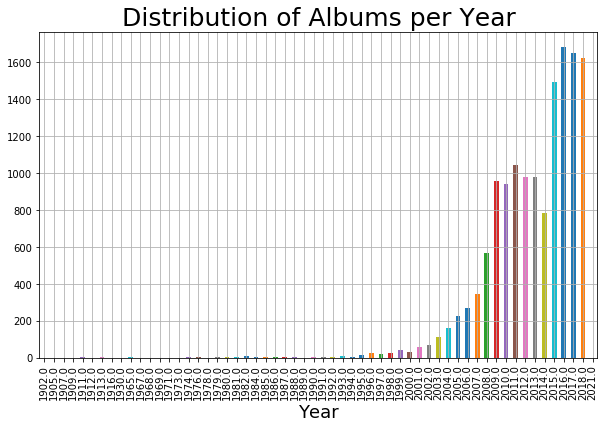

In [5]:
album_dist = albums_df.groupby(albums_df['album_date_released'].dt.year).size()

def dist_album_year():
    album_dist.plot(kind='bar')
    plt.grid()
    plt.xticks(rotation=90)

std_plot(dist_album_year, title='Distribution of Albums per Year',
         xlabel='Year')


In the graph we can observe that the quantity of albums grew exponentially with the years. 
And because we want to focus on the music from 90's to Milenials we will define our data set between the years 2000-2018.

In [6]:
start_date=pd.Timestamp(2000, 1, 1, 0)
end_date=pd.Timestamp(2018,12,12,23)
albums_df = albums_df[(albums_df.album_date_released > start_date) & (albums_df.album_date_released < end_date ) ]


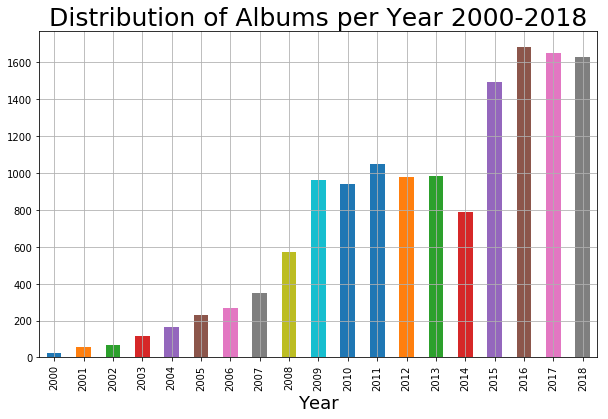

In [7]:
album_dist = albums_df.groupby(albums_df['album_date_released'].dt.year).size()

def dist_album_year():
    album_dist.plot(kind='bar')
    plt.grid()
    plt.xticks(rotation=90)

std_plot(dist_album_year, title='Distribution of Albums per Year 2000-2018',
         xlabel='Year')

We do the same analysis for the tracks, first visualize to confirm that follows a similar pattern as the albums

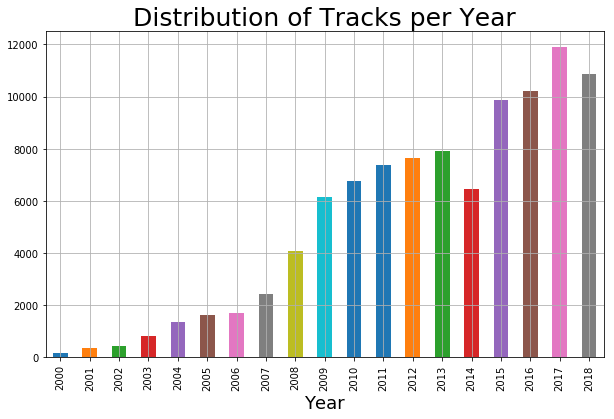

In [8]:
tracks_albums = tracks_df.merge(albums_df)
tracks_dist = tracks_albums.groupby(tracks_albums['album_date_released'].dt.year).size()

def dist_tracks_year():
    tracks_dist.plot(kind='bar')
    plt.grid()
    plt.xticks(rotation=90)

std_plot(dist_tracks_year, title='Distribution of Tracks per Year',
         xlabel='Year')


In [9]:
tracks_filtered = tracks_albums[(tracks_albums.album_date_released > start_date)\
                                & (tracks_albums.album_date_released < end_date ) ]

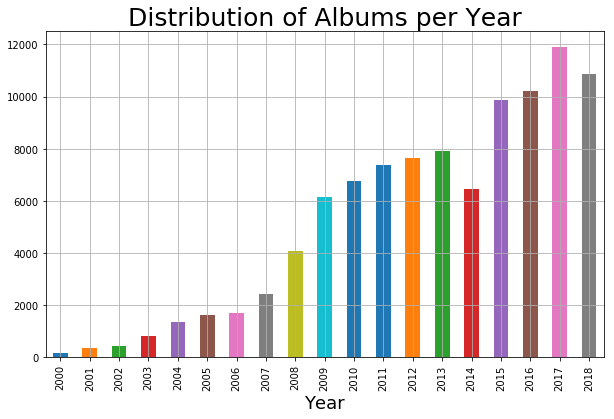

In [10]:
album_dist = tracks_filtered.groupby(tracks_albums['album_date_released'].dt.year).size()

def dist_album_year():
    album_dist.plot(kind='bar')
    plt.grid()
    plt.xticks(rotation=90)

std_plot(dist_album_year, title='Distribution of Albums per Year',
         xlabel='Year')

And like in the previous picture since the albums grow exponentialy the tracks follow the same pattern.
Now the next step is to locate which country is the one with the highset proportion of production of tracks

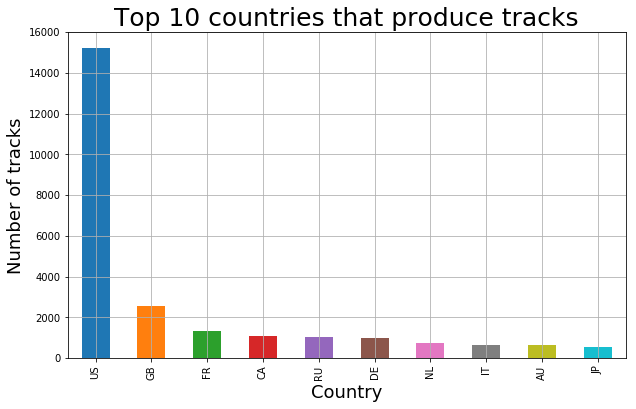

In [11]:
tracks_df = tracks_filtered
track_artist = tracks_df.merge(artists_df, left_on='artist_id', 
                               right_on='artist_id')
country_grouped = track_artist.groupby(track_artist['country']).size()
country_top10 = country_grouped.sort_values(ascending=False) \
                                     .head(10)

def country_track_top10():
    country_top10.plot(kind='bar')
    plt.ylabel('Number of Tracks')
    plt.grid()
    
std_plot(country_track_top10, title='Top 10 countries that produce tracks',
         ylabel='Number of tracks', xlabel='Country')


We can observe that the top country producing tracks is the US, with a substancial difference comparing 20000 to 5000 with the next country Great Britain.

#### Top 10 albums
The top 10 albums 

C:\Users\Andres Montero\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


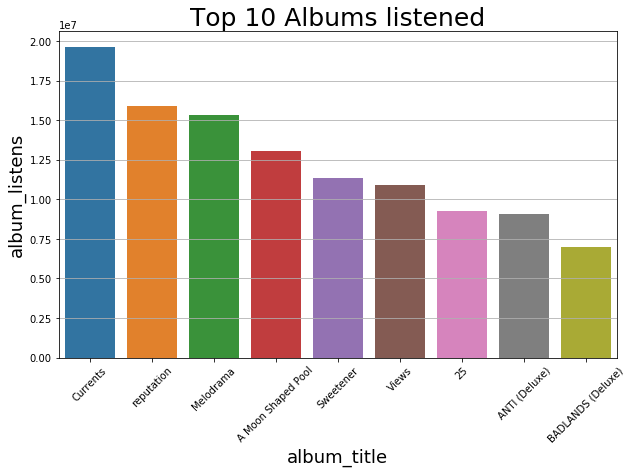

In [12]:
# albums_df=album_filtered.copy()
# albums_top10=albums_df.sort_values(by=['album_listens'],ascending=False).head(10)
albums_grouped = albums_df.groupby(albums_df['album_id']) \
                          .first()[['album_title', 'album_listens']]
albums_top10 = albums_grouped.sort_values(by='album_listens', 
                                          ascending=False).head(10)

def album_listen_top10():
    plt.grid()
    sns.barplot(x='album_title', y='album_listens',
                data=albums_top10)
    plt.xticks(rotation=45)
    
std_plot(album_listen_top10, title='Top 10 Albums listened')


#### Top 10 Tracks

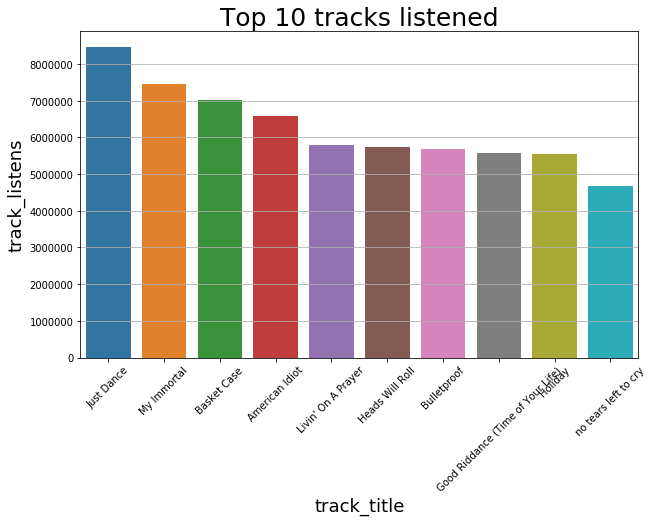

In [13]:
# tracks_df=tracks_filtered
# tracks_top10=tracks_df.sort_values(by=['track_listens'],ascending=False).head(10)

tracks_grouped = tracks_albums.groupby(tracks_df['track_id']) \
                          .first()[['track_title', 'track_listens']]
tracks_top10 = tracks_grouped.sort_values(by='track_listens', 
                                          ascending=False).head(10)

def track_listen_top10():
    plt.grid()
    sns.barplot(x='track_title', y= 'track_listens',
                data=tracks_top10)
    plt.xticks(rotation=45)
    
std_plot(track_listen_top10, title='Top 10 tracks listened')


#### Clustering using danceability, energy, valence and hotness features
Now we will try to find if there are similar tracks regarding to danceability, energy, valence and hotness, and group them;


In [14]:
def reduce_tsne(data, reduce_to=2):
    tsne = TSNE(n_components=reduce_to, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(data)
    print('TSNE Done!')
    return tsne_results

tsne_path = '{pkl}{tsne}'.format(pkl=PKL_DIR , tsne='tsne.pkl')
track_artist_reduced = tracks_df.sample(frac=0.125).merge(artists_df)

if os.path.exists(tsne_path):
    data = pd.read_pickle(tsne_path)
else:
    features = track_artist_reduced.fillna(0)[FEATURES]
    kmeans = KMeans(n_clusters=8)  
    kmeans.fit(features) 

    coord = reduce_tsne(features, reduce_to=3)

    d = {'x': coord[:, 0] , 'y': coord[:, 1], 'z': coord[:, 2], 
         'cluster': kmeans.labels_}

    data = pd.DataFrame(data=d)
    pd.to_pickle(data, tsne_path)
    
data = pd.concat([data, track_artist_reduced], axis=1)
data = data.merge(albums_df).merge(track_genre_rel_df).merge(genres_df)
data['year'] = data['album_date_released'].dt.year
data_filter = data[['x', 'y', 'z', 'cluster', 'track_title', 
                    'album_title', 'artist_name', 'genre_parent', 'year']]
data_filter.to_csv('../{csv}{file}'.format(csv=CSV_DIR, file='tsne.csv'))
data_filter.head()


,x,y,z,cluster,track_title,album_title,artist_name,genre_parent,year
0,-15.671057,75.005463,109.819077,0.0,She Vang Moon,Amidst The Noise And Twigs,Volcano the Bear,Experimental,2012
1,3.237318,-190.799149,21.855618,0.0,Splendid Goose,Amidst The Noise And Twigs,Volcano the Bear,Experimental,2012
2,0.963239,0.601782,-1.196779,0.0,Shake Your Crow,The Idea Of Wood,Volcano the Bear,Experimental,2003
3,-28.656506,-29.502886,-13.156504,0.0,THE OPEN THE CLOSED & THE GOD-LIKE SHUTTER,The Shy Volcanic Society At The Bear And Bird ...,Volcano the Bear,Experimental,2009
4,-3.508903,-1.996256,1.977953,2.0,Track 25,Free Matter for the Blind Volume 5: FILE Under...,Free Matter for the Blind,Experimental,2003


#### Relation between danceability and duration of the song
Now we will try to find correlation between different features of the tracks, in this case the danceability and the duration of the song

In [15]:
tracks_df.insert(loc=13, column='track_duration_minutes',
                 value=(tracks_df['track_duration'] / 60))

tracks_df['track_duration_minutes'] = pd.to_numeric( \
                                            tracks_df['track_duration_minutes'])


C:\Users\Andres Montero\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


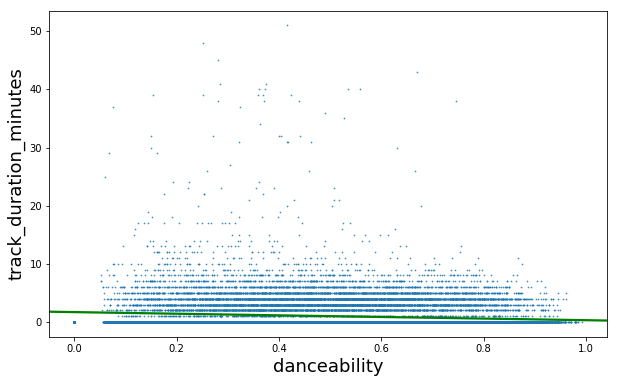

In [16]:
tracks_df['track_duration_minutes'] = tracks_df['track_duration_minutes'] \
                                                .apply(lambda x : np.rint(x))

def danceability_track_duration():
    sns.regplot(x='danceability', y='track_duration_minutes',
                data=tracks_df, ci=95, 
                line_kws = {'color': 'green'},
                scatter_kws={'s': 0.5})
    
std_plot(danceability_track_duration)


In the previous plot we can see that there is no clear correlation between danceability and the duration of the tracks, and to support this hypthesis we calculate the Spearman and Pearson Coefficient

In [17]:
tracks_df_correlation = tracks_df.dropna()
spearman_coeff = stats.spearmanr(tracks_df_correlation['danceability'], 
                                 tracks_df_correlation['track_duration_minutes'])
print('The spearman correlation is: {}'.format(spearman_coeff))


The spearman correlation is: SpearmanrResult(correlation=-0.060766632475942106, pvalue=8.288526842333769e-05)


In [18]:
pearson_coeff = stats.pearsonr(tracks_df_correlation['danceability'], 
                                 tracks_df_correlation['track_duration_minutes'])
print('The pearson correlation is: {}'.format(pearson_coeff))

The pearson correlation is: (-0.11393933329755772, 1.3906889993226056e-13)


* With the previous results of the Spearman and Pearson coefficients, we conclude that there is no direct strong correlation between the duration of the tracks and the danceability


## Relation between valence and other variables

One of the key features of the tracks is "Valence", which refers to the degree of positive or negative emotions one perceives from a song. We'll try to find some relations between this feature and the other key features "Danceability" and "Energy".


C:\Users\Andres Montero\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


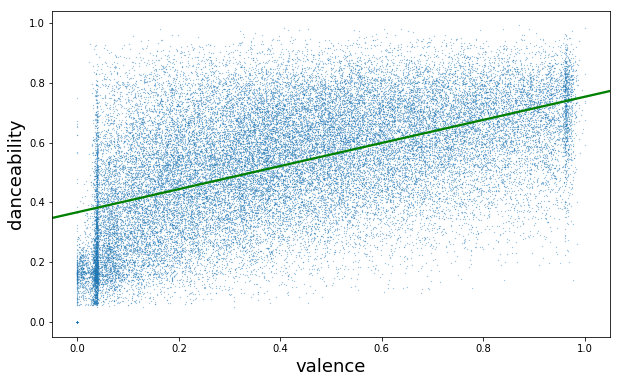

In [19]:
def danceability_valence():
    sns.regplot(x='valence', y='danceability',
                data=tracks_df, ci=95, 
                line_kws = {'color': 'green'},
                scatter_kws={'s': 0.05})
    
std_plot(danceability_valence)


As we can observe in the previous plot there is a moderate positive correlation between the valence and danceability, to confirm this we calculate the Spearman and Pearson correlation.

In [20]:
spearman_coeff = stats.spearmanr(tracks_df_correlation['valence'], 
                                 tracks_df_correlation['danceability'])
print('The spearman correlation is: {}'.format(spearman_coeff))


The spearman correlation is: SpearmanrResult(correlation=0.4642506491085091, pvalue=4.657841876096804e-223)


In [21]:
pearson_coeff = stats.pearsonr(tracks_df_correlation['valence'], 
                                 tracks_df_correlation['danceability'])
print('The pearson correlation is: {}'.format(pearson_coeff))

The pearson correlation is: (0.4643482734097751, 3.6559097447239514e-223)


* With the previous results of the Spearman and Pearson coefficients, we conclude that there is moderate correlation between the valence and the danceability of a track

C:\Users\Andres Montero\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


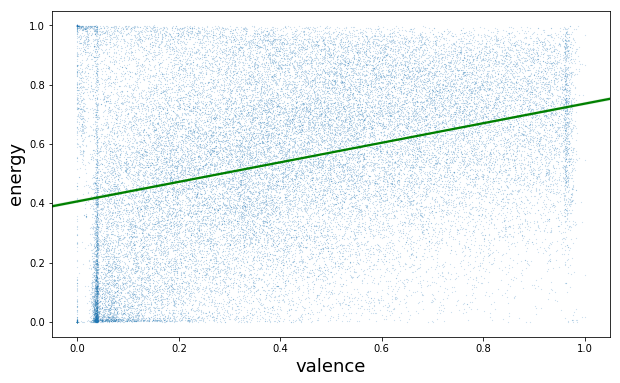

In [22]:
def track_listen_valence():
    sns.regplot(x='valence', y='energy',
                data=tracks_df, ci=95, 
                line_kws ={'color': 'green'}, 
                scatter_kws={'s': 0.01})
    
std_plot(track_listen_valence)


In [23]:
spearman_coeff = stats.spearmanr(tracks_df_correlation['valence'], 
                                 tracks_df_correlation['energy'])
print('The spearman correlation is: {}'.format(spearman_coeff))


The spearman correlation is: SpearmanrResult(correlation=0.15459554476098686, pvalue=7.922690539152465e-24)


In [24]:
pearson_coeff = stats.pearsonr(tracks_df_correlation['valence'], 
                                 tracks_df_correlation['energy'])
print('The pearson correlation is: {}'.format(pearson_coeff))

The pearson correlation is: (0.1630679738877856, 2.3182074323071108e-26)


* With the previous results of the Spearman and Pearson coefficients, we conclude that there is low correlation between the valence and the energy of a track

## Top tracks/genres

As we have seen that the valence has correlation between Energy and Danceability, so we conclude that this is an important feature and we will make a plot with the top genres with the highest average valence

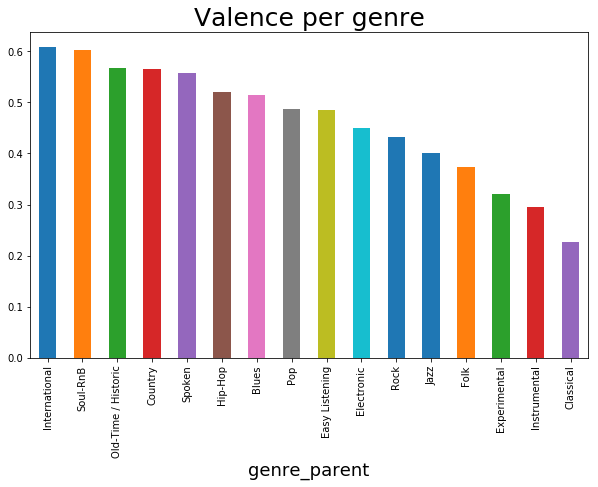

In [25]:
track_rel = tracks_df.merge(track_genre_rel_df)
track_genre = track_rel.merge(genres_df)
genre_valence = track_genre.groupby('genre_parent')['valence'].mean()

top10_genre_valence = genre_valence.sort_values(ascending=False)

def genre_valence_top10():
    top10_genre_valence.plot(kind='bar')
       
std_plot(genre_valence_top10, title='Valence per genre')

As we can see in the previous graph the genre with the highest average valence is "International" so we will explore this genre with more detail.

Then we will focus to see which genre was the one with the most releases per year.

In [26]:
track_genre_album = track_genre.merge(albums_df)

genre_year = track_genre_album[['genre_parent', 'album_date_released']]
genre_year.insert(loc=2, column='album_released_year',
                  value=(genre_year['album_date_released'].dt.year))


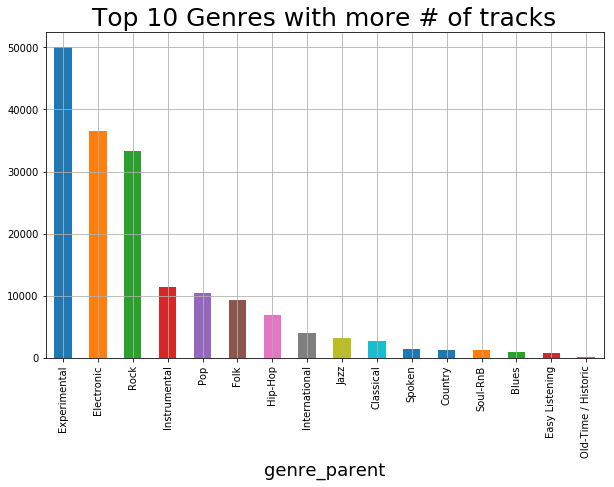

In [27]:
top_genre = genre_year.groupby(genre_year['genre_parent']).size()
top_genre_sorted = top_genre.sort_values(ascending=False)

def genres_num_track_top10():
    top_genre_sorted.plot(kind='bar')
    plt.grid()

std_plot(genres_num_track_top10,
         title='Top 10 Genres with more # of tracks')

We can observe that the genre with the highest number of tracks is experimental followed closely by electronic

The next plot shows the top 10 Genres according to the popularity of that song, this is a key plot as we will observe that is the top genre over the las 18 years according to the "Hotness" of the artist and the tracks.

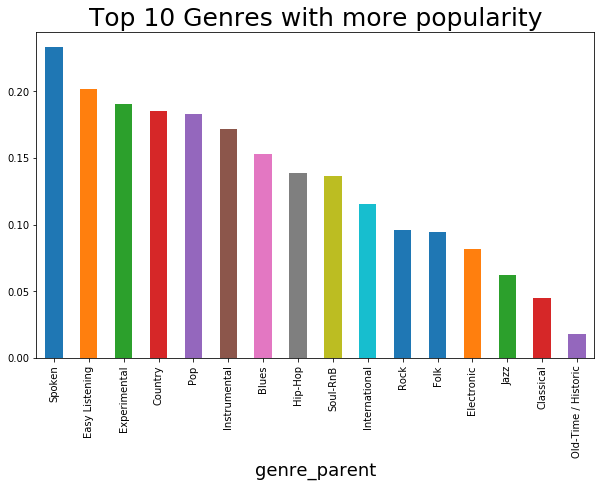

In [28]:
# Top Genres with more popularity
genre_popularity = track_genre.groupby('genre_parent')['song_hotness'].mean()
top10_genre_popularity = genre_popularity.sort_values(ascending=False)

def genre_popularity_top10():
    top10_genre_popularity.plot(kind='bar')
    
std_plot(genre_popularity_top10, 
         title='Top 10 Genres with more popularity')


We can observe that the most popular genre according to the "Hotness" is Spoken, which is a emerging genre specially on Spotify.

# TOP ARTIST THROUGHT YEARS SINCE 2000

The next section is to analyze the top artists over the las 18 years, this analysis will separated depending on the :

-Artist_Hotness, -Track_Hotness and -Barplots over each year to see the evolution 

<Figure size 720x432 with 0 Axes>

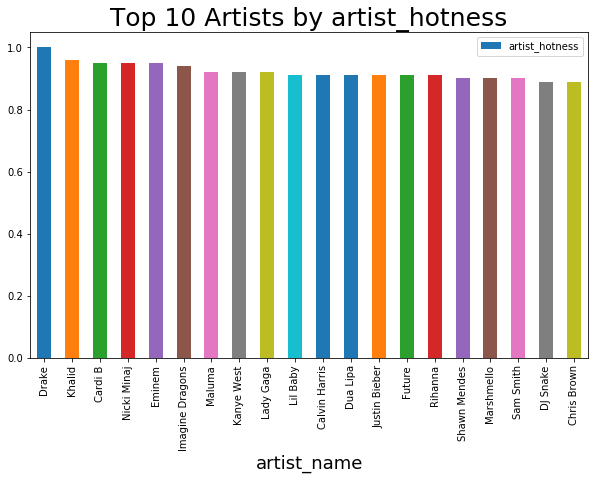

In [29]:
# Top 10 artists by artists_hotness
top10_artists = artists_df[['artist_name', 'artist_hotness']] \
                    .sort_values(by='artist_hotness',
                                 ascending=False).head(20)

def artists_top10():
    return top10_artists.plot(x='artist_name', y='artist_hotness',
                              kind='bar')
    
std_plot(artists_top10, title='Top 10 Artists by artist_hotness')


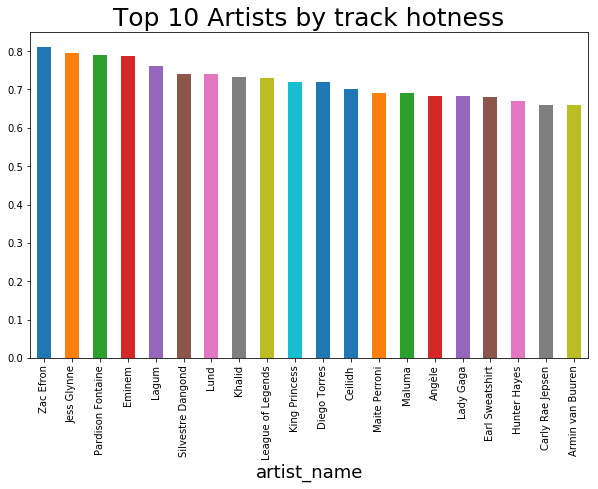

In [30]:
# Top 10 artists by tracks popularity
track_artist = tracks_df.merge(artists_df)
track_hotness_artist = track_artist.groupby('artist_name')['song_hotness'].mean()
top10_artists = track_hotness_artist.sort_values(ascending=False).head(20)

def artists_top10():
    top10_artists.plot(kind='bar')
    
std_plot(artists_top10, title='Top 10 Artists by track hotness')


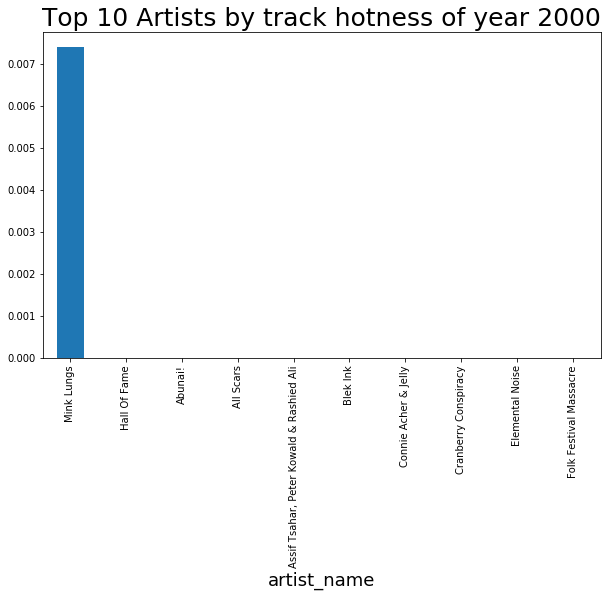

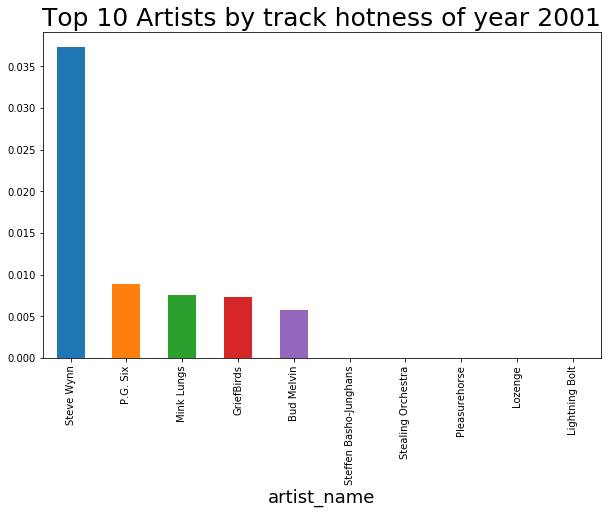

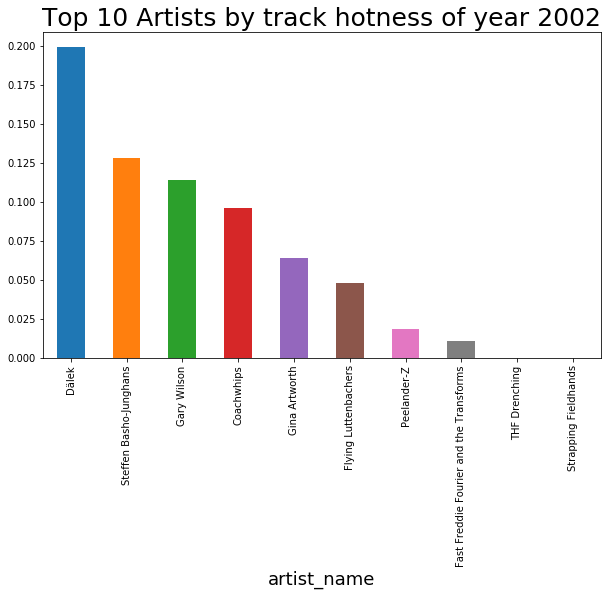

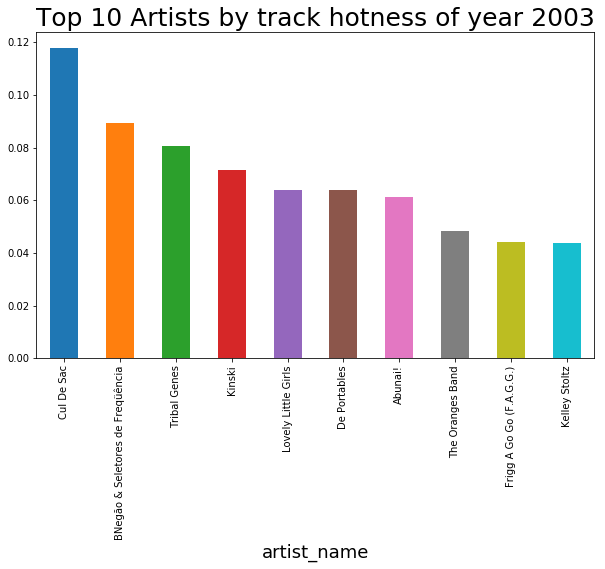

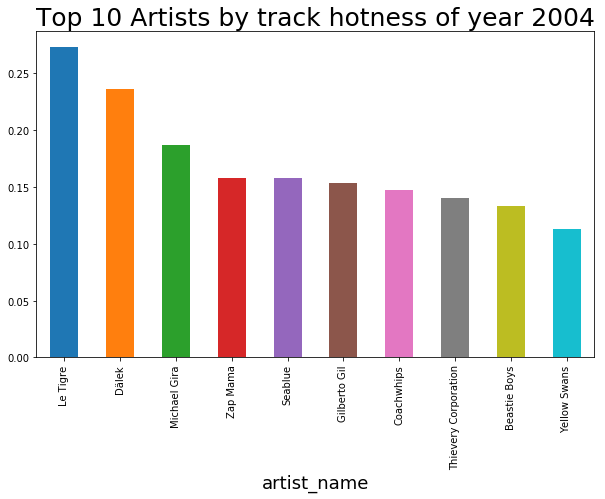

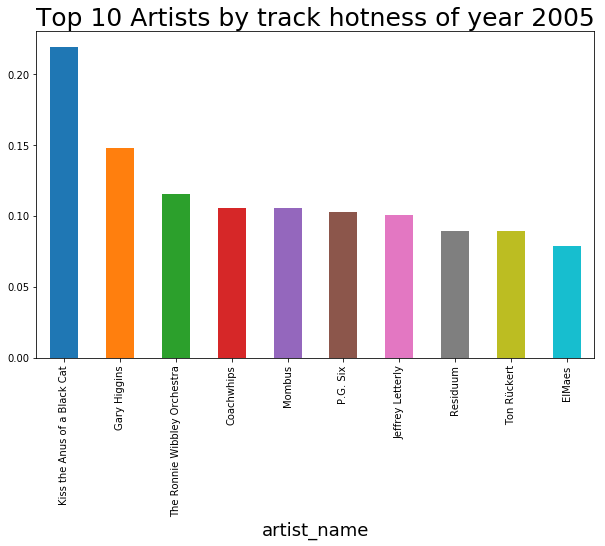

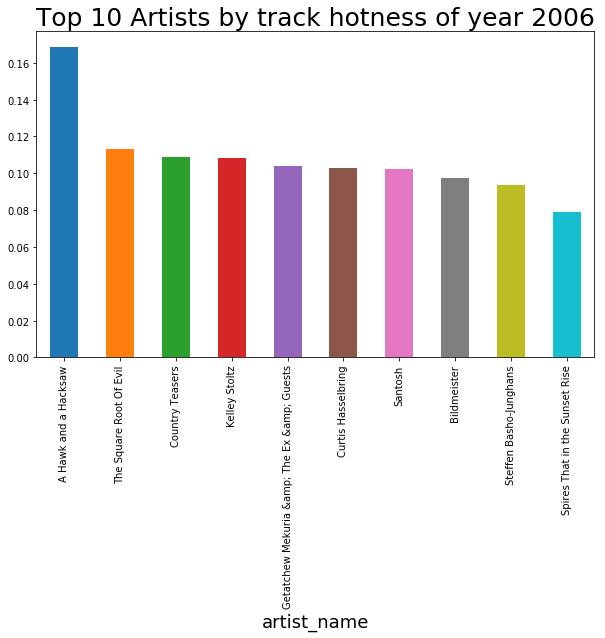

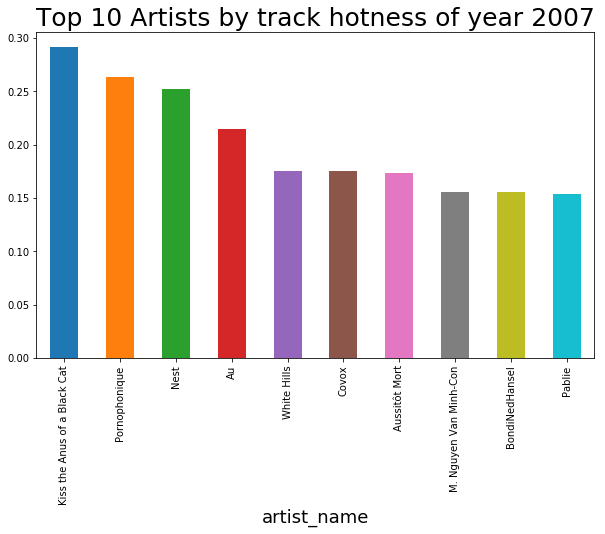

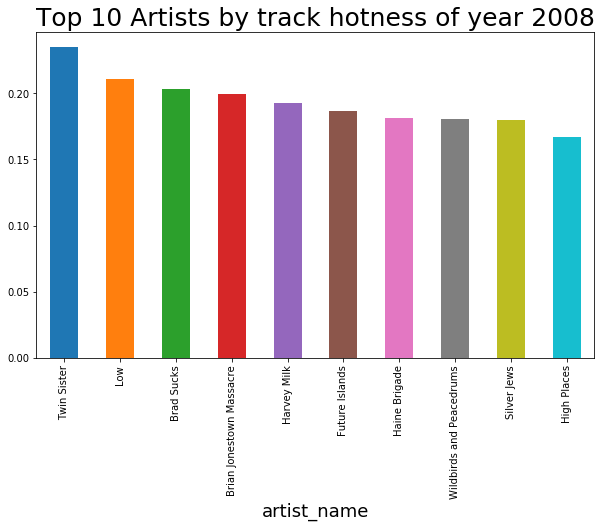

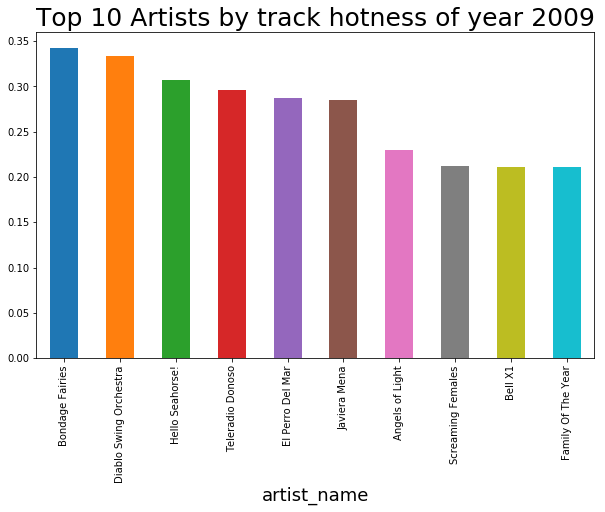

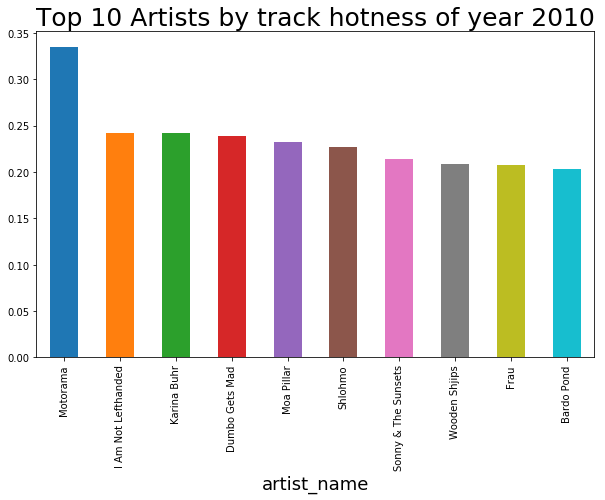

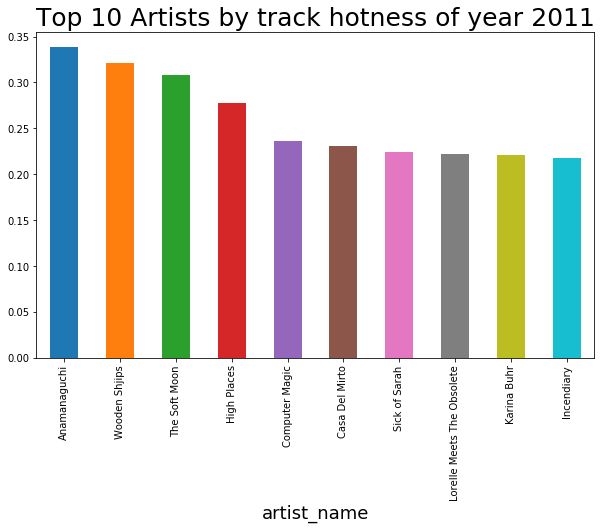

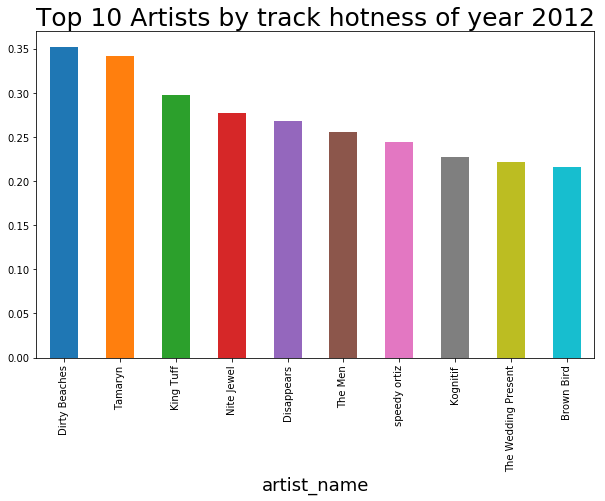

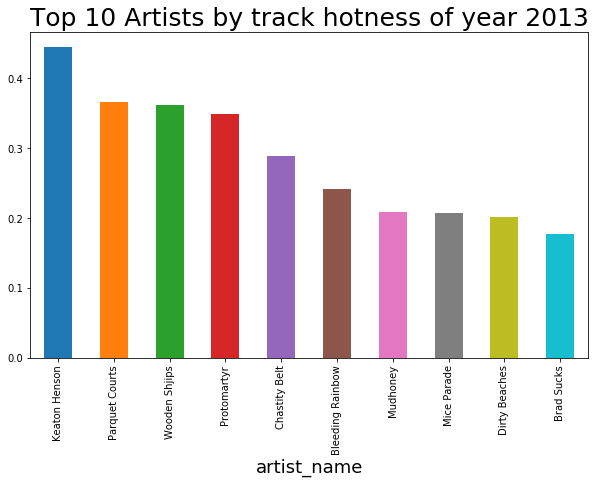

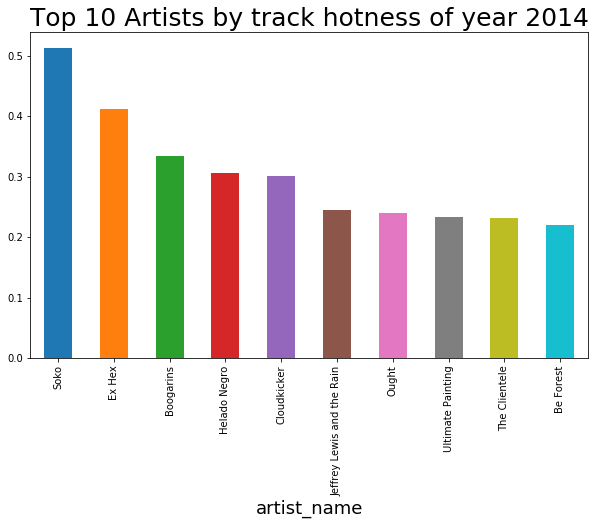

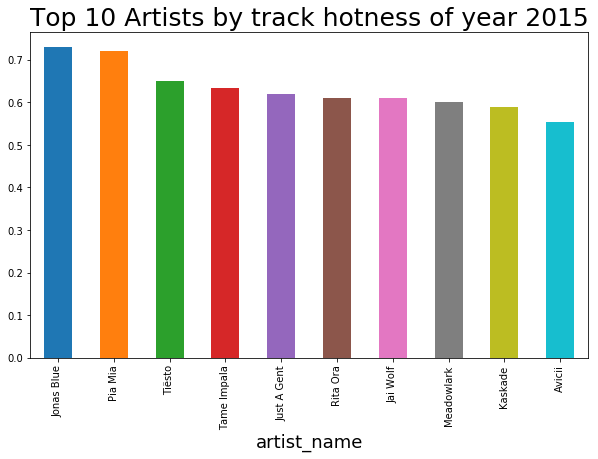

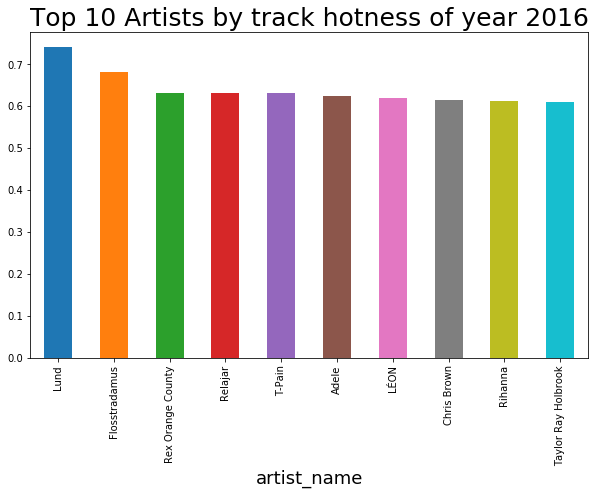

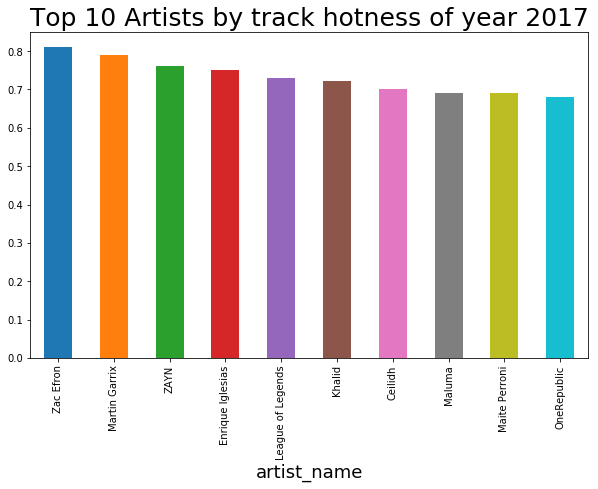

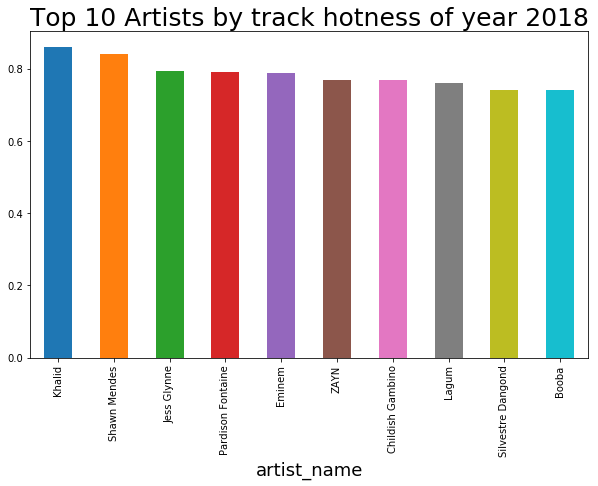

In [31]:
# Top Artists Evolution since 2000 by year
tracks_albums_artists = tracks_df.merge(albums_df).merge(artists_df)

for year in range(2000, 2019):
    is_from_year = tracks_albums_artists['album_date_released'].dt.year == year
    filter_tracks = tracks_albums_artists[is_from_year]
    
    track_hotness_artist = filter_tracks.groupby('artist_name')['song_hotness'].mean()
    top10_artists = track_hotness_artist.sort_values(ascending=False).head(10)

    def artists_top10():
        top10_artists.plot(kind='bar')

    std_plot(artists_top10, title='Top 10 Artists by track hotness of year {}'.format(year))
    

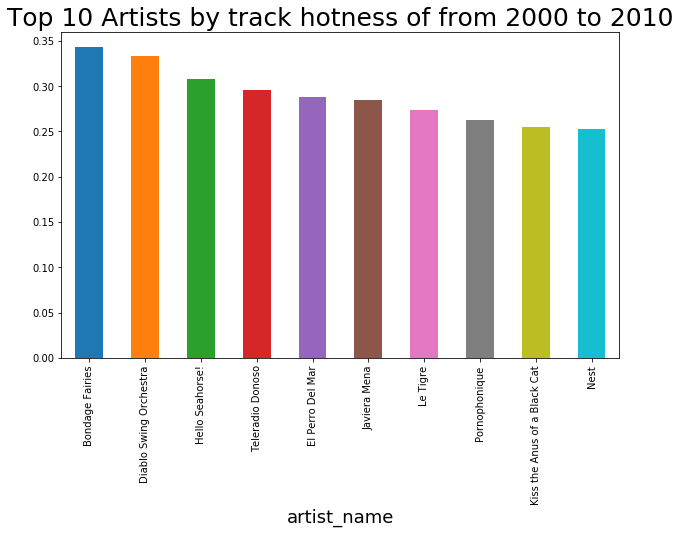

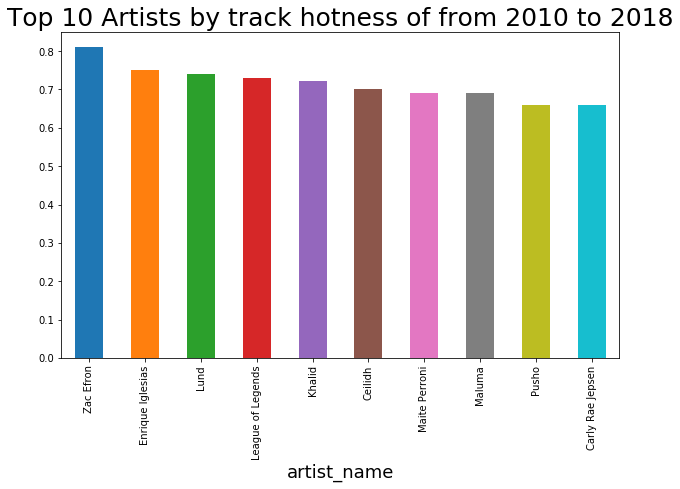

In [32]:
# Top Artists Evolution since 2000 by year interval
interval_y = [(2000, 2010), (2010, 2018)]

for from_y, to_y in interval_y:
    album_released_year = tracks_albums_artists['album_date_released'].dt.year
    from_y_cond =  album_released_year >= from_y
    to_y_cond = album_released_year < to_y
    is_from_to_y = from_y_cond & to_y_cond
    filter_tracks = tracks_albums_artists[is_from_to_y]
    
    track_hotness_artist = filter_tracks.groupby('artist_name')['song_hotness'].mean()
    top10_artists = track_hotness_artist.sort_values(ascending=False).head(10)

    def artists_top10():
        top10_artists.plot(kind='bar')

    std_plot(artists_top10, 
             title='Top 10 Artists by track hotness of from {from_y} to {to_y}'.format(from_y=from_y,
                                                                                       to_y=to_y))

## Evolution of music Valence/Energy/Danceability

This section is to analyze the evolution of the music depending on the key features of "Valence", "Energy" and "Danceability".

In [33]:
tracks_albums = tracks_df.merge(albums_df, how='inner')


We will focus on the the seasons evolution: "Summer", "Winter", "Spring" and "Autum"

In [34]:
tracks_albums_summer = tracks_albums.loc[lambda tracks_albums: (tracks_albums.album_date_released.dt.month >5)\
                 & (tracks_albums.album_date_released.dt.month <9)]
tracks_albums_winter = tracks_albums.loc[lambda tracks_albums: ((tracks_albums.album_date_released.dt.month >11)\
                 | (tracks_albums.album_date_released.dt.month <3))]
tracks_albums_spring = tracks_albums.loc[lambda tracks_albums: (tracks_albums.album_date_released.dt.month >2)\
                 & (tracks_albums.album_date_released.dt.month <6)]
tracks_albums_autumn = tracks_albums.loc[lambda tracks_albums: (tracks_albums.album_date_released.dt.month >8)\
                 & (tracks_albums.album_date_released.dt.month <12)]


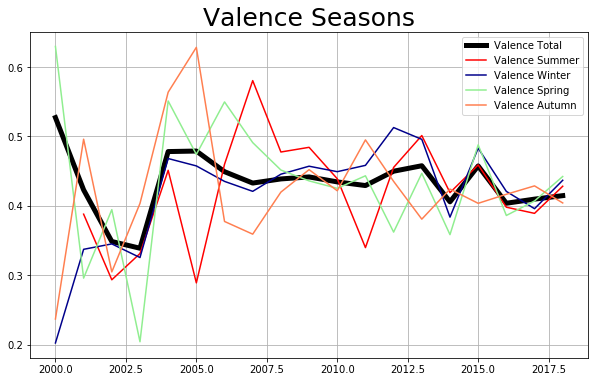

In [35]:
#summer
tracks_albums_summer_year = tracks_albums_summer.groupby([(tracks_albums_summer['album_date_released'].dt.year.rename('year')),\
                          (tracks_albums_summer['album_date_released'].dt.month.rename('month'))]).mean()

tracks_albums_summer_year_mean = tracks_albums_summer_year.groupby('year').mean()
tracks_albums_summer_year_mean_valence = tracks_albums_summer_year_mean[['valence']]

# winter

tracks_albums_winter_year = tracks_albums_winter.groupby([(tracks_albums_winter['album_date_released'].dt.year.rename('year')),\
                          (tracks_albums_winter['album_date_released'].dt.month.rename('month'))]).mean()

tracks_albums_winter_year_mean = tracks_albums_winter_year.groupby('year').mean()
tracks_albums_winter_year_mean_valence = tracks_albums_winter_year_mean[['valence']]

#spring
tracks_albums_spring_year = tracks_albums_spring.groupby([(tracks_albums_spring['album_date_released'].dt.year.rename('year')),\
                          (tracks_albums_spring['album_date_released'].dt.month.rename('month'))]).mean()

tracks_albums_spring_year_mean = tracks_albums_spring_year.groupby('year').mean()
tracks_albums_spring_year_mean_valence = tracks_albums_spring_year_mean[['valence']]

#autumn
tracks_albums_autumn_year = tracks_albums_autumn.groupby([(tracks_albums_autumn['album_date_released'].dt.year.rename('year')),\
                          (tracks_albums_autumn['album_date_released'].dt.month.rename('month'))]).mean()

tracks_albums_autumn_year_mean = tracks_albums_autumn_year.groupby('year').mean()
tracks_albums_autumn_year_mean_valence = tracks_albums_autumn_year_mean[['valence']]

tracks_albums_total = tracks_albums.groupby([(tracks_albums['album_date_released'].dt.year.rename('year'))\
                                                           ]).mean()
tracks_albums_total_valence = tracks_albums_total[['valence']]

def valence_seasons():
    plt.grid()
    sns.lineplot(data=tracks_albums_total_valence["valence"],
                 color="black", label="Valence Total", linewidth=5)
    sns.lineplot(data=tracks_albums_summer_year_mean_valence["valence"],
                 color="red", label="Valence Summer")
    sns.lineplot(data=tracks_albums_winter_year_mean_valence["valence"], 
                 color="darkblue", label="Valence Winter")
    sns.lineplot(data=tracks_albums_spring_year_mean_valence["valence"], 
                 color="lightgreen", label="Valence Spring")
    return sns.lineplot(data=tracks_albums_autumn_year_mean_valence["valence"], 
                        color="coral", label="Valence Autumn")

std_plot(valence_seasons, title='Valence Seasons')


From the previous graphic we can observe that the valence of the music in general had a significant decrease from the 2000 until 2002, then there is a rise around 2004 and after that remains estable between 0.4 and 0.5

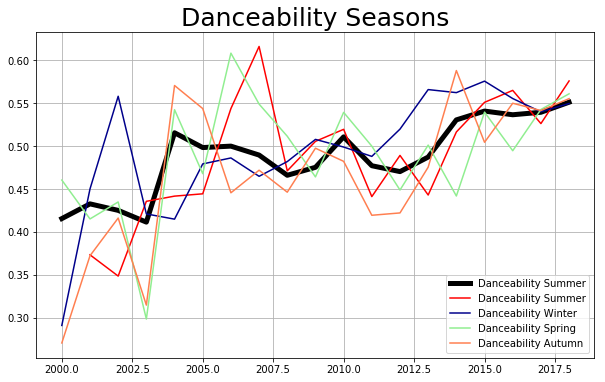

In [36]:
tracks_albums_summer_year_mean = tracks_albums_summer_year.groupby('year').mean()
tracks_albums_summer_year_mean_danceability = tracks_albums_summer_year_mean[['danceability']]

tracks_albums_winter_year_mean = tracks_albums_winter_year.groupby('year').mean()
tracks_albums_winter_year_mean_danceability = tracks_albums_winter_year_mean[['danceability']]

tracks_albums_spring_year_mean = tracks_albums_spring_year.groupby('year').mean()
tracks_albums_spring_year_mean_danceability = tracks_albums_spring_year_mean[['danceability']]

tracks_albums_autumn_year_mean = tracks_albums_autumn_year.groupby('year').mean()
tracks_albums_autumn_year_mean_danceability = tracks_albums_autumn_year_mean[['danceability']]

tracks_albums_total = tracks_albums.groupby([(tracks_albums['album_date_released'].dt.year.rename('year'))\
                                                           ]).mean()
tracks_albums_total_valence = tracks_albums_total[['danceability']]

def valence_seasons():
    plt.grid()
    sns.lineplot(data=tracks_albums_total_valence["danceability"], 
                 color="black", label="Danceability Summer", linewidth=5)
    sns.lineplot(data=tracks_albums_summer_year_mean_danceability["danceability"], 
                 color="red", label="Danceability Summer")
    sns.lineplot(data=tracks_albums_winter_year_mean_danceability["danceability"],
                 color="darkblue", label="Danceability Winter")
    sns.lineplot(data=tracks_albums_spring_year_mean_danceability["danceability"], 
                 color="lightgreen", label="Danceability Spring")
    return sns.lineplot(data=tracks_albums_autumn_year_mean_danceability["danceability"],
                        color="coral", label="Danceability Autumn")

std_plot(valence_seasons, title='Danceability Seasons')


From the previous graphic we can observe that the danceability of the music increased since the 2000's, with almost doubled value in 2018, the season of the year were the most danceably songs are realeased is winter as you can observe in the previous plot (blue line).

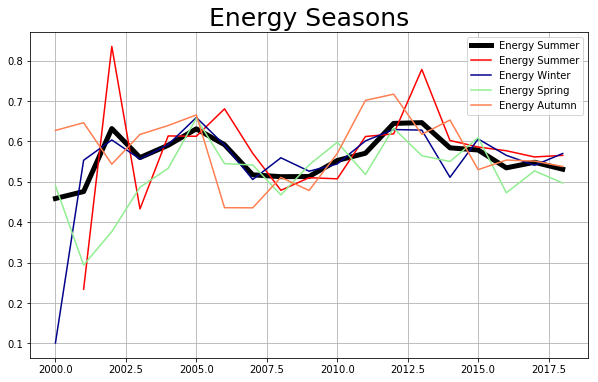

In [37]:
tracks_albums_summer_year_mean = tracks_albums_summer_year.groupby('year').mean()
tracks_albums_summer_year_mean_energy = tracks_albums_summer_year_mean[['energy']]

tracks_albums_winter_year_mean = tracks_albums_winter_year.groupby('year').mean()
tracks_albums_winter_year_mean_energy = tracks_albums_winter_year_mean[['energy']]

tracks_albums_spring_year_mean = tracks_albums_spring_year.groupby('year').mean()
tracks_albums_spring_year_mean_energy = tracks_albums_spring_year_mean[['energy']]

tracks_albums_autumn_year_mean = tracks_albums_autumn_year.groupby('year').mean()
tracks_albums_autumn_year_mean_energy = tracks_albums_autumn_year_mean[['energy']]

tracks_albums_total = tracks_albums.groupby([(tracks_albums['album_date_released'].dt.year.rename('year'))\
                                                           ]).mean()
tracks_albums_total_valence = tracks_albums_total[['energy']]

def energy_seasons():
    plt.grid()
    sns.lineplot(data=tracks_albums_total_valence["energy"], 
                 color="black", label="Energy Summer", linewidth=5)
    sns.lineplot(data=tracks_albums_summer_year_mean_energy["energy"], 
                 color="red", label="Energy Summer")
    sns.lineplot(data=tracks_albums_winter_year_mean_energy["energy"],
                 color="darkblue", label="Energy Winter")
    sns.lineplot(data=tracks_albums_spring_year_mean_energy["energy"],
                 color="lightgreen", label="Energy Spring")
    return sns.lineplot(data=tracks_albums_autumn_year_mean_energy["energy"],
                        color="coral", label="Energy Autumn")

std_plot(energy_seasons, title='Energy Seasons')


The highest period in terms of energy of the music is around 2012 with a value of almost 0.65, however this value decreased in the last years, and is showing a decreassing trend as you can observe in the previous plot.

## Evolution of music 2000-2010 Valence/Energy/Danceability Seasons

The following section will do a more extensive research about the key features of the tracks on the period of 2000-2010.

In [38]:
#sumer
tracks_albums_summer_2000 = tracks_albums.loc[lambda tracks_albums: (tracks_albums.album_date_released.dt.month >5)\
                 & (tracks_albums.album_date_released.dt.month <9) \
                 & (tracks_albums.album_date_released.dt.year >1999)\
                 & (tracks_albums.album_date_released.dt.year <2010)                           ]
tracks_albums_summer_2000_year = tracks_albums_summer_2000.groupby([(tracks_albums_summer_2000['album_date_released'].dt.year.rename('year')),\
                          (tracks_albums_summer_2000['album_date_released'].dt.month.rename('month'))]).mean()

#winter
tracks_albums_winter_2000 = tracks_albums.loc[lambda tracks_albums: ((tracks_albums.album_date_released.dt.month <3)\
                 | (tracks_albums.album_date_released.dt.month >11)) \
                 & (tracks_albums.album_date_released.dt.year >1999)\
                 & (tracks_albums.album_date_released.dt.year <2010)                           ]
tracks_albums_winter_2000_year = tracks_albums_winter_2000.groupby([(tracks_albums_winter_2000['album_date_released'].dt.year.rename('year')),\
                          (tracks_albums_winter_2000['album_date_released'].dt.month.rename('month'))]).mean()

#spring
tracks_albums_spring_2000 = tracks_albums.loc[lambda tracks_albums: (tracks_albums.album_date_released.dt.month >2)\
                 & (tracks_albums.album_date_released.dt.month <6) \
                 & (tracks_albums.album_date_released.dt.year >1999)\
                 & (tracks_albums.album_date_released.dt.year <2010)                           ]
tracks_albums_spring_2000_year = tracks_albums_spring_2000.groupby([(tracks_albums_spring_2000['album_date_released'].dt.year.rename('year')),\
                          (tracks_albums_spring_2000['album_date_released'].dt.month.rename('month'))]).mean()

#autumn
tracks_albums_autumn_2000 = tracks_albums.loc[lambda tracks_albums: (tracks_albums.album_date_released.dt.month >8)\
                 & (tracks_albums.album_date_released.dt.month <12) \
                 & (tracks_albums.album_date_released.dt.year >1999)\
                 & (tracks_albums.album_date_released.dt.year <2010)                           ]
tracks_albums_autumn_2000_year = tracks_albums_autumn_2000.groupby([(tracks_albums_autumn_2000['album_date_released'].dt.year.rename('year')),\
                          (tracks_albums_autumn_2000['album_date_released'].dt.month.rename('month'))]).mean()
#total
tracks_albums_total_2000 = tracks_albums.loc[lambda tracks_albums:(tracks_albums.album_date_released.dt.year >1999)\
                 & (tracks_albums.album_date_released.dt.year <2010)]
tracks_albums_total_2000_year = tracks_albums_total_2000.groupby([(tracks_albums_total_2000['album_date_released'].dt.year.rename('year'))]).mean()


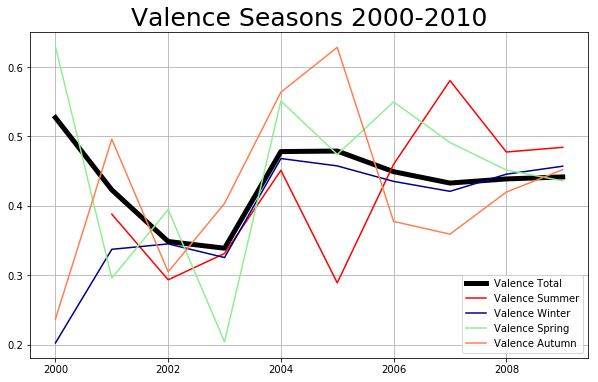

In [39]:
#summer
tracks_albums_summer_2000_year_mean = tracks_albums_summer_2000_year.groupby('year').mean()
tracks_albums_summer_2000_year_mean_valence = tracks_albums_summer_2000_year_mean[['valence']]
#winter
tracks_albums_winter_2000_year_mean = tracks_albums_winter_2000_year.groupby('year').mean()
tracks_albums_winter_2000_year_mean_valence = tracks_albums_winter_2000_year_mean[['valence']]
#spring
tracks_albums_spring_2000_year_mean = tracks_albums_spring_2000_year.groupby('year').mean()
tracks_albums_spring_2000_year_mean_valence = tracks_albums_spring_2000_year_mean[['valence']]
#autumn
tracks_albums_autumn_2000_year_mean = tracks_albums_autumn_2000_year.groupby('year').mean()
tracks_albums_autumn_2000_year_mean_valence = tracks_albums_autumn_2000_year_mean[['valence']]
#total
tracks_albums_total_2000_mean = tracks_albums_total_2000_year.groupby('year').mean()
tracks_albums_total_2000_mean_valence = tracks_albums_total_2000_mean[['valence']]

def valence_seasons_00_10():
    plt.grid()
    sns.lineplot(data=tracks_albums_total_2000_mean_valence["valence"], 
                 color="black", label="Valence Total", linewidth=5)
    sns.lineplot(data=tracks_albums_summer_2000_year_mean_valence["valence"], 
                 color="red", label="Valence Summer")
    sns.lineplot(data=tracks_albums_winter_2000_year_mean_valence["valence"],
                 color="darkblue", label="Valence Winter")
    sns.lineplot(data=tracks_albums_spring_2000_year_mean_valence["valence"], 
                 color="lightgreen", label="Valence Spring")
    return sns.lineplot(data=tracks_albums_autumn_2000_year_mean_valence["valence"], 
                        color="coral", label="Valence Autumn")

std_plot(valence_seasons_00_10, title='Valence Seasons 2000-2010')
    

In [40]:
def plot_function_seasons(summary_df,feature,period):
    N = len(summary_df)
    ind = np.arange(N) 
    width = 0.15
    fig = plt.figure(figsize=(13,7))
    ax = fig.add_subplot(111)
    yvals = summary_df.winter
    rects1 = ax.bar(ind, yvals, width,color="lightskyblue")
    zvals = summary_df.spring
    rects2 = ax.bar(ind+width+0.01, zvals, width,color="darkseagreen")
    kvals = summary_df.summer
    rects3 = ax.bar(ind+width*2+0.02, kvals, width,color="lightcoral")
    xvals = summary_df.autumn
    rects4 = ax.bar(ind+width*2+width+0.03, xvals, width,color="burlywood")
    
    ax.set_xlabel('Year')
    ax.set_ylabel(feature)
    ax.set_xticks(ind+width)
    ax.set_xticklabels( (summary_df.index.values) )
    ax.legend( (rects1[0], rects2[0], rects3[0],rects4[0]), ('winter', 'spring', 'summer','autumn') )
    plt.grid()
    plt.title(str(feature)+" in the period "+str(period))
    plt.show()
    

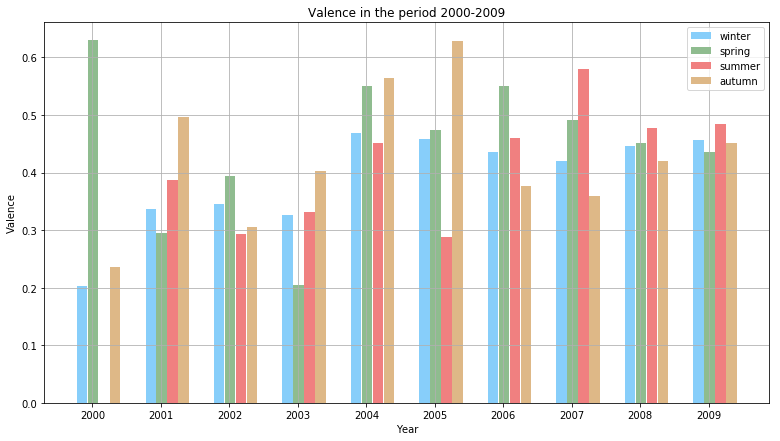

In [41]:
summary_valence_2000=pd.merge(pd.merge(tracks_albums_summer_2000_year_mean_valence,tracks_albums_winter_2000_year_mean_valence , on='year'),
        pd.merge(tracks_albums_spring_2000_year_mean_valence,tracks_albums_autumn_2000_year_mean_valence , on='year'),on='year')
summary_valence_2000.columns=['summer', 'winter', 'spring', 'autumn']
summary_valence_2000

plot_function_seasons(summary_valence_2000,'Valence',period='2000-2009')

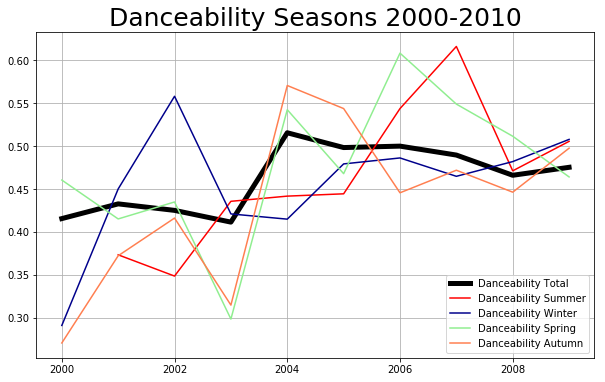

In [42]:
#summer
tracks_albums_summer_2000_year_mean = tracks_albums_summer_2000_year.groupby('year').mean()
tracks_albums_summer_2000_year_mean_dancebility = tracks_albums_summer_2000_year_mean[['danceability']]

#winter
tracks_albums_winter_2000_year_mean = tracks_albums_winter_2000_year.groupby('year').mean()
tracks_albums_winter_2000_year_mean_dancebility = tracks_albums_winter_2000_year_mean[['danceability']]

#spring
tracks_albums_spring_2000_year_mean = tracks_albums_spring_2000_year.groupby('year').mean()
tracks_albums_spring_2000_year_mean_dancebility = tracks_albums_spring_2000_year_mean[['danceability']]

#autumn
tracks_albums_autumn_2000_year_mean = tracks_albums_autumn_2000_year.groupby('year').mean()
tracks_albums_autumn_2000_year_mean_dancebility = tracks_albums_autumn_2000_year_mean[['danceability']]
#total
tracks_albums_total_2000_mean = tracks_albums_total_2000_year.groupby('year').mean()
tracks_albums_total_2000_mean_valence = tracks_albums_total_2000_mean[['danceability']]

def danceability_seasons_00_10():
    plt.grid()
    sns.lineplot(data=tracks_albums_total_2000_mean_valence["danceability"], 
                 color="black", label="Danceability Total", linewidth=5)
    sns.lineplot(data=tracks_albums_summer_2000_year_mean_dancebility["danceability"],
                 color="red", label="Danceability Summer")
    sns.lineplot(data=tracks_albums_winter_2000_year_mean_dancebility["danceability"], 
                 color="darkblue", label="Danceability Winter")
    sns.lineplot(data=tracks_albums_spring_2000_year_mean_dancebility["danceability"],
                 color="lightgreen", label="Danceability Spring")
    return sns.lineplot(data=tracks_albums_autumn_2000_year_mean_dancebility["danceability"],
                        color="coral", label="Danceability Autumn")

std_plot(danceability_seasons_00_10, title='Danceability Seasons 2000-2010')
    

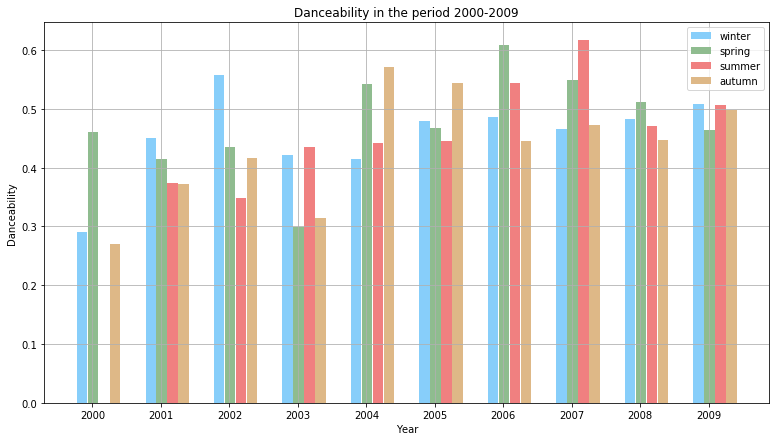

In [43]:
summary_danceability_2000=pd.merge(pd.merge(tracks_albums_summer_2000_year_mean_dancebility,tracks_albums_winter_2000_year_mean_dancebility , on='year'),
        pd.merge(tracks_albums_spring_2000_year_mean_dancebility,tracks_albums_autumn_2000_year_mean_dancebility , on='year'),on='year')
summary_danceability_2000.columns=['summer', 'winter', 'spring', 'autumn']
summary_danceability_2000

plot_function_seasons(summary_danceability_2000,'Danceability',period='2000-2009')

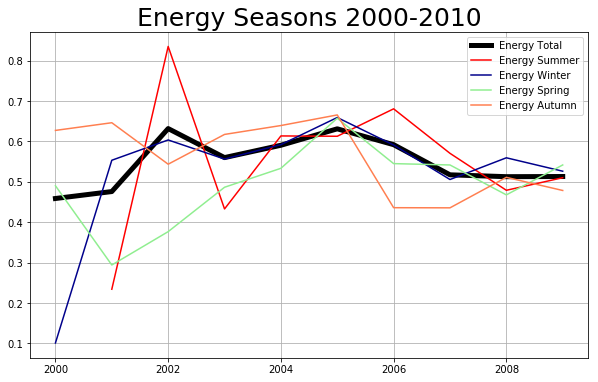

In [44]:
#summer
tracks_albums_summer_2000_year_mean = tracks_albums_summer_2000_year.groupby('year').mean()
tracks_albums_summer_2000_year_mean_energy = tracks_albums_summer_2000_year_mean[['energy']]

# winter
tracks_albums_winter_2000_year_mean = tracks_albums_winter_2000_year.groupby('year').mean()
tracks_albums_winter_2000_year_mean_energy = tracks_albums_winter_2000_year_mean[['energy']]

#spring
tracks_albums_spring_2000_year_mean = tracks_albums_spring_2000_year.groupby('year').mean()
tracks_albums_spring_2000_year_mean_energy = tracks_albums_spring_2000_year_mean[['energy']]

#autumn
tracks_albums_autumn_2000_year_mean = tracks_albums_autumn_2000_year.groupby('year').mean()
tracks_albums_autumn_2000_year_mean_energy = tracks_albums_autumn_2000_year_mean[['energy']]
#total
tracks_albums_total_2000_mean = tracks_albums_total_2000_year.groupby('year').mean()
tracks_albums_total_2000_mean_valence = tracks_albums_total_2000_mean[['energy']]

def energy_seasons_00_10():
    plt.grid()
    sns.lineplot(data=tracks_albums_total_2000_mean_valence["energy"], 
                 color="black", label="Energy Total", linewidth=5)
    sns.lineplot(data=tracks_albums_summer_2000_year_mean_energy["energy"],
                 color="red", label="Energy Summer")
    sns.lineplot(data=tracks_albums_winter_2000_year_mean_energy["energy"],
                 color="darkblue", label="Energy Winter")
    sns.lineplot(data=tracks_albums_spring_2000_year_mean_energy["energy"],
                 color="lightgreen", label="Energy Spring")
    return sns.lineplot(data=tracks_albums_autumn_2000_year_mean_energy["energy"], 
                        color="coral", label="Energy Autumn")

std_plot(energy_seasons_00_10, title='Energy Seasons 2000-2010')


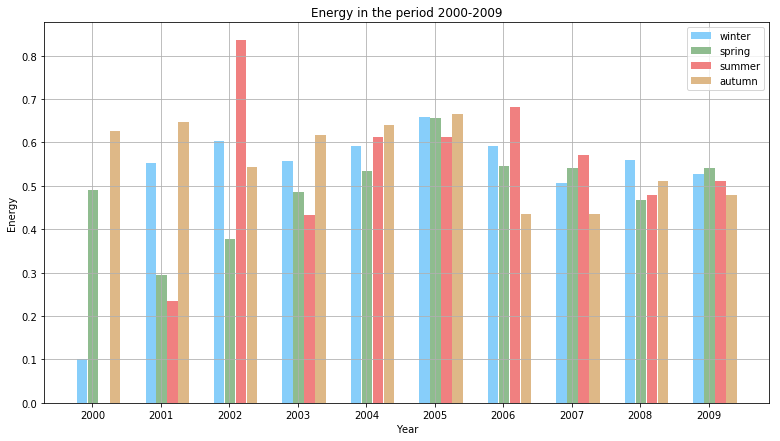

In [45]:
summary_energy_2000=pd.merge(pd.merge(tracks_albums_summer_2000_year_mean_energy,tracks_albums_winter_2000_year_mean_energy , on='year'),
        pd.merge(tracks_albums_spring_2000_year_mean_energy,tracks_albums_autumn_2000_year_mean_energy , on='year'),on='year')
summary_energy_2000.columns=['summer', 'winter', 'spring', 'autumn']
summary_energy_2000

plot_function_seasons(summary_energy_2000,'Energy',period='2000-2009')

## Evolution of music 2010-2018 Valence/Energy/Danceability

In [46]:
#summer
tracks_albums_summer_2010 = tracks_albums.loc[lambda tracks_albums: (tracks_albums.album_date_released.dt.month >5)\
                 & (tracks_albums.album_date_released.dt.month <9) \
                 & (tracks_albums.album_date_released.dt.year >2009)]
tracks_albums_summer_2010_year = tracks_albums_summer_2010.groupby([(tracks_albums_summer_2010['album_date_released'].dt.year.rename('year')),\
                          (tracks_albums_summer_2010['album_date_released'].dt.month.rename('month'))]).mean()

#winter
tracks_albums_winter_2010 = tracks_albums.loc[lambda tracks_albums: ((tracks_albums.album_date_released.dt.month <3)\
                 | (tracks_albums.album_date_released.dt.month >11)) \
                 & (tracks_albums.album_date_released.dt.year >2009)]
tracks_albums_winter_2010_year = tracks_albums_winter_2010.groupby([(tracks_albums_winter_2010['album_date_released'].dt.year.rename('year')),\
                          (tracks_albums_winter_2010['album_date_released'].dt.month.rename('month'))]).mean()

#spring
tracks_albums_spring_2010 = tracks_albums.loc[lambda tracks_albums: (tracks_albums.album_date_released.dt.month >2)\
                 & (tracks_albums.album_date_released.dt.month <6) \
                 & (tracks_albums.album_date_released.dt.year >2009)]
tracks_albums_spring_2010_year = tracks_albums_spring_2010.groupby([(tracks_albums_spring_2010['album_date_released'].dt.year.rename('year')),\
                          (tracks_albums_spring_2010['album_date_released'].dt.month.rename('month'))]).mean()

#autumn
tracks_albums_autumn_2010 = tracks_albums.loc[lambda tracks_albums: (tracks_albums.album_date_released.dt.month >8)\
                 & (tracks_albums.album_date_released.dt.month <12) \
                 & (tracks_albums.album_date_released.dt.year >2009)]
tracks_albums_autumn_2010_year = tracks_albums_autumn_2010.groupby([(tracks_albums_autumn_2010['album_date_released'].dt.year.rename('year')),\
                          (tracks_albums_autumn_2010['album_date_released'].dt.month.rename('month'))]).mean()
#total
tracks_albums_total_2010 = tracks_albums.loc[lambda tracks_albums:(tracks_albums.album_date_released.dt.year >2009)\
                 & (tracks_albums.album_date_released.dt.year <2019)]
tracks_albums_total_2010_year = tracks_albums_total_2010.groupby([(tracks_albums_total_2010['album_date_released'].dt.year.rename('year'))]).mean()


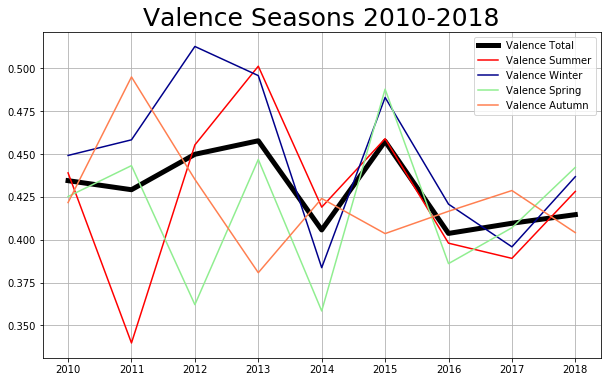

In [47]:
#summer
tracks_albums_summer_2010_year_mean = tracks_albums_summer_2010_year.groupby('year').mean()
tracks_albums_summer_2010_year_mean_valence = tracks_albums_summer_2010_year_mean[['valence']]

#winter
tracks_albums_winter_2010_year_mean = tracks_albums_winter_2010_year.groupby('year').mean()
tracks_albums_winter_2010_year_mean_valence = tracks_albums_winter_2010_year_mean[['valence']]

#spring
tracks_albums_spring_2010_year_mean = tracks_albums_spring_2010_year.groupby('year').mean()
tracks_albums_spring_2010_year_mean_valence = tracks_albums_spring_2010_year_mean[['valence']]

#autumn
tracks_albums_autumn_2010_year_mean = tracks_albums_autumn_2010_year.groupby('year').mean()
tracks_albums_autumn_2010_year_mean_valence = tracks_albums_autumn_2010_year_mean[['valence']]

#total
tracks_albums_total_2010_mean = tracks_albums_total_2010_year.groupby('year').mean()
tracks_albums_total_2010_mean_valence = tracks_albums_total_2010_mean[['valence']]

def valence_seasons_10_18():
    plt.grid()
    sns.lineplot(data=tracks_albums_total_2010_mean_valence["valence"], 
                 color="black", label="Valence Total", linewidth=5)
    sns.lineplot(data=tracks_albums_summer_2010_year_mean_valence["valence"],
                 color="red", label="Valence Summer")
    sns.lineplot(data=tracks_albums_winter_2010_year_mean_valence["valence"], 
                 color="darkblue", label="Valence Winter")
    sns.lineplot(data=tracks_albums_spring_2010_year_mean_valence["valence"], 
                 color="lightgreen", label="Valence Spring")
    return sns.lineplot(data=tracks_albums_autumn_2010_year_mean_valence["valence"], 
                        color="coral", label="Valence Autumn")

std_plot(valence_seasons_10_18, title='Valence Seasons 2010-2018')


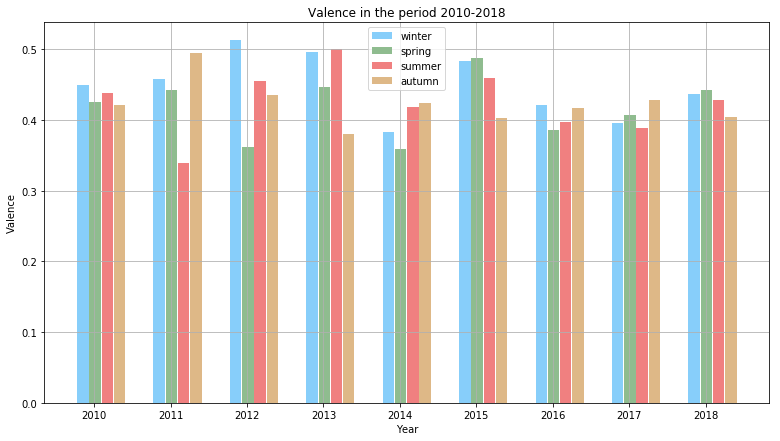

In [48]:
summary_valence_2010=pd.merge(pd.merge(tracks_albums_summer_2010_year_mean_valence,tracks_albums_winter_2010_year_mean_valence , on='year'),
        pd.merge(tracks_albums_spring_2010_year_mean_valence,tracks_albums_autumn_2010_year_mean_valence , on='year'),on='year')
summary_valence_2010.columns=['summer', 'winter', 'spring', 'autumn']
summary_valence_2010

plot_function_seasons(summary_valence_2010,'Valence',period='2010-2018')

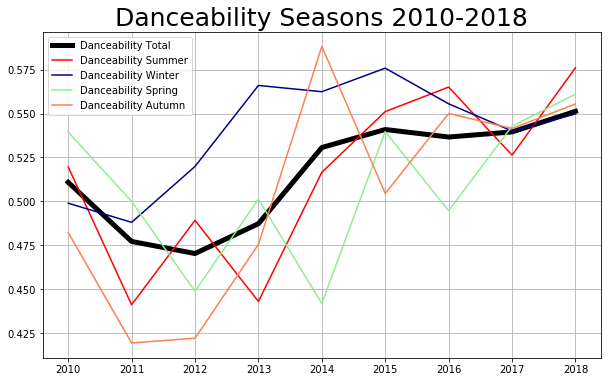

In [49]:
#summer
tracks_albums_summer_2010_year_mean = tracks_albums_summer_2010_year.groupby('year').mean()
tracks_albums_summer_2010_year_mean_danceability= tracks_albums_summer_2010_year_mean[['danceability']]

#winter
tracks_albums_winter_2010_year_mean = tracks_albums_winter_2010_year.groupby('year').mean()
tracks_albums_winter_2010_year_mean_danceability = tracks_albums_winter_2010_year_mean[['danceability']]

#spring
tracks_albums_spring_2010_year_mean = tracks_albums_spring_2010_year.groupby('year').mean()
tracks_albums_spring_2010_year_mean_danceability = tracks_albums_spring_2010_year_mean[['danceability']]

#autumn
tracks_albums_autumn_2010_year_mean = tracks_albums_autumn_2010_year.groupby('year').mean()
tracks_albums_autumn_2010_year_mean_danceability = tracks_albums_autumn_2010_year_mean[['danceability']]

#total
tracks_albums_total_2010_mean = tracks_albums_total_2010_year.groupby('year').mean()
tracks_albums_total_2010_mean_valence = tracks_albums_total_2010_mean[['danceability']]

def danceability_seasons_10_18():
    plt.grid()
    sns.lineplot(data=tracks_albums_total_2010_mean_valence["danceability"], 
                 color="black", label="Danceability Total", linewidth=5)
    sns.lineplot(data=tracks_albums_summer_2010_year_mean_danceability["danceability"],
                 color="red", label="Danceability Summer")
    sns.lineplot(data=tracks_albums_winter_2010_year_mean_danceability["danceability"],
                 color="darkblue", label="Danceability Winter")
    sns.lineplot(data=tracks_albums_spring_2010_year_mean_danceability["danceability"],
                 color="lightgreen", label="Danceability Spring")
    return sns.lineplot(data=tracks_albums_autumn_2010_year_mean_danceability["danceability"],
                        color="coral", label="Danceability Autumn")

std_plot(danceability_seasons_10_18, title='Danceability Seasons 2010-2018')


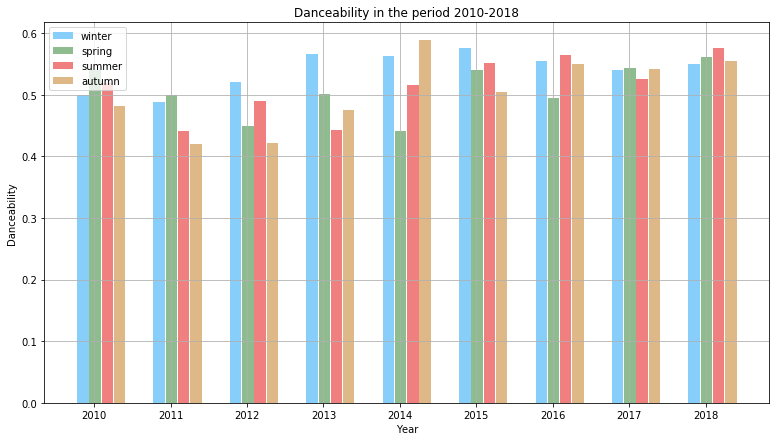

In [50]:
summary_danceability_2010=pd.merge(pd.merge(tracks_albums_summer_2010_year_mean_danceability,tracks_albums_winter_2010_year_mean_danceability , on='year'),
        pd.merge(tracks_albums_spring_2010_year_mean_danceability,tracks_albums_autumn_2010_year_mean_danceability , on='year'),on='year')
summary_danceability_2010.columns=['summer', 'winter', 'spring', 'autumn']
summary_danceability_2010

plot_function_seasons(summary_danceability_2010,'Danceability',period='2010-2018')

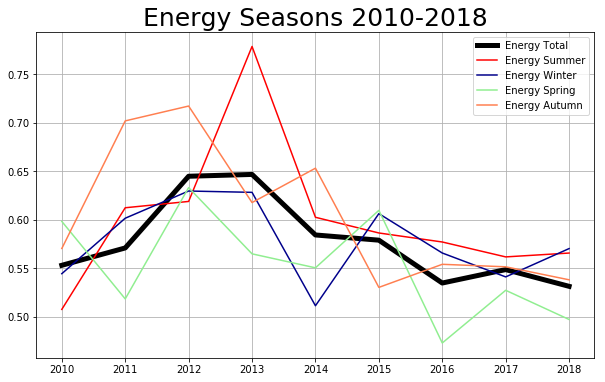

In [51]:
#summer
tracks_albums_summer_2010_year_mean = tracks_albums_summer_2010_year.groupby('year').mean()
tracks_albums_summer_2010_year_mean_energy = tracks_albums_summer_2010_year_mean[['energy']]

#winter
tracks_albums_winter_2010_year_mean = tracks_albums_winter_2010_year.groupby('year').mean()
tracks_albums_winter_2010_year_mean_energy = tracks_albums_winter_2010_year_mean[['energy']]

#spring
tracks_albums_spring_2010_year_mean = tracks_albums_spring_2010_year.groupby('year').mean()
tracks_albums_spring_2010_year_mean_energy = tracks_albums_spring_2010_year_mean[['energy']]

#autumn
tracks_albums_autumn_2010_year_mean = tracks_albums_autumn_2010_year.groupby('year').mean()
tracks_albums_autumn_2010_year_mean_energy = tracks_albums_autumn_2010_year_mean[['energy']]

#total
tracks_albums_total_2010_mean = tracks_albums_total_2010_year.groupby('year').mean()
tracks_albums_total_2010_mean_valence = tracks_albums_total_2010_mean[['energy']]

def energy_seasons_10_18():
    plt.grid()
    sns.lineplot(data=tracks_albums_total_2010_mean_valence["energy"], 
                 color="black", label="Energy Total", linewidth=5)
    sns.lineplot(data=tracks_albums_summer_2010_year_mean_energy["energy"], 
                 color="red", label="Energy Summer")
    sns.lineplot(data=tracks_albums_winter_2010_year_mean_energy["energy"],
                 color="darkblue", label="Energy Winter")
    sns.lineplot(data=tracks_albums_spring_2010_year_mean_energy["energy"],
                 color="lightgreen", label="Energy Spring")
    return sns.lineplot(data=tracks_albums_autumn_2010_year_mean_energy["energy"],
                        color="coral", label="Energy Autumn")

std_plot(energy_seasons_10_18, title='Energy Seasons 2010-2018')


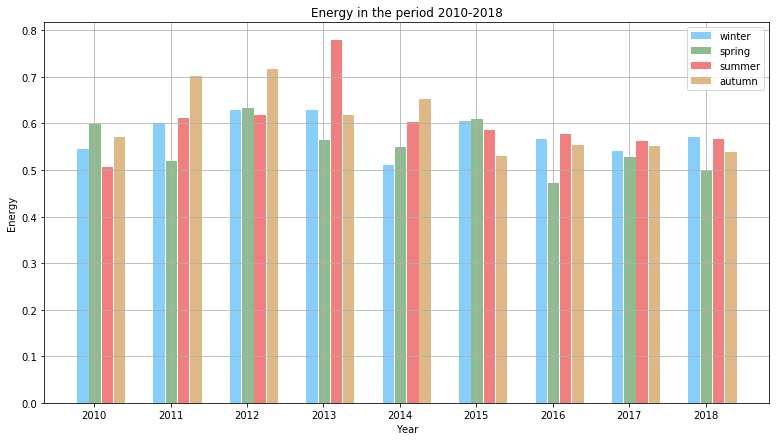

In [52]:
summary_energy_2010=pd.merge(pd.merge(tracks_albums_summer_2010_year_mean_energy,tracks_albums_winter_2010_year_mean_energy , on='year'),
        pd.merge(tracks_albums_spring_2010_year_mean_energy,tracks_albums_autumn_2010_year_mean_energy , on='year'),on='year')
summary_energy_2010.columns=['summer', 'winter', 'spring', 'autumn']
summary_energy_2010

plot_function_seasons(summary_energy_2010,'Energy',period='2010-2018')

In the previous plots we observed the evolution with noisy plots, to fix this problem we will proceed to the next section.

## Evolution of music 2000-2010 Valence/Energy/Danceability Seasons 
##### With categorical value of 2 to reduce noise 

The following section will explain with more detailed the evolution of the key features of the tracks, now we impliment categorical values to group every two years.

In [53]:
#sumer
tracks_albums_summer_2000 = tracks_albums.loc[lambda tracks_albums: (tracks_albums.album_date_released.dt.month >5)\
                 & (tracks_albums.album_date_released.dt.month <9) \
                 & (tracks_albums.album_date_released.dt.year >1999)\
                 & (tracks_albums.album_date_released.dt.year <2010)]
tracks_albums_summer_2000 = tracks_albums_summer_2000.copy()
tracks_albums_summer_2000['categorical_year'] = pd.cut(tracks_albums_summer_2000['album_date_released'].dt.year, \
                                                       [2000, 2002, 2004, 2006, 2008, 2010], \
                                                       labels=[2002, 2004, 2006, 2008, 2010])
tracks_albums_summer_2000_year = tracks_albums_summer_2000.groupby('categorical_year').mean()

#winter
tracks_albums_winter_2000 = tracks_albums.loc[lambda tracks_albums: ((tracks_albums.album_date_released.dt.month <3)\
                 | (tracks_albums.album_date_released.dt.month >11)) \
                 & (tracks_albums.album_date_released.dt.year >1999)\
                 & (tracks_albums.album_date_released.dt.year <2010)]
tracks_albums_winter_2000 = tracks_albums_winter_2000.copy()
tracks_albums_winter_2000['categorical_year'] = pd.cut(tracks_albums_winter_2000['album_date_released'].dt.year, \
                                                        [2000, 2002, 2004, 2006, 2008, 2010], \
                                                       labels=[2002, 2004, 2006, 2008, 2010])
tracks_albums_winter_2000_year = tracks_albums_winter_2000.groupby('categorical_year').mean()

#spring
tracks_albums_spring_2000 = tracks_albums.loc[lambda tracks_albums: (tracks_albums.album_date_released.dt.month >2)\
                 & (tracks_albums.album_date_released.dt.month <6) \
                 & (tracks_albums.album_date_released.dt.year >1999)\
                 & (tracks_albums.album_date_released.dt.year <2010)]
tracks_albums_spring_2000 = tracks_albums_spring_2000.copy()
tracks_albums_spring_2000['categorical_year'] = pd.cut(tracks_albums_spring_2000['album_date_released'].dt.year, \
                                                        [2000, 2002, 2004, 2006, 2008, 2010], \
                                                       labels=[2002, 2004, 2006, 2008, 2010])
tracks_albums_spring_2000_year = tracks_albums_spring_2000.groupby('categorical_year').mean()

#autumn
tracks_albums_autumn_2000 = tracks_albums.loc[lambda tracks_albums: (tracks_albums.album_date_released.dt.month >8)\
                 & (tracks_albums.album_date_released.dt.month <12) \
                 & (tracks_albums.album_date_released.dt.year >1999)\
                 & (tracks_albums.album_date_released.dt.year <2010)]
tracks_albums_autumn_2000 = tracks_albums_autumn_2000.copy()
tracks_albums_autumn_2000['categorical_year'] = pd.cut(tracks_albums_autumn_2000['album_date_released'].dt.year, \
                                                        [2000, 2002, 2004, 2006, 2008, 2010], \
                                                       labels=[2002, 2004, 2006, 2008, 2010])
tracks_albums_autumn_2000_year = tracks_albums_autumn_2000.groupby('categorical_year').mean()

#total
tracks_albums_total_2000 = tracks_albums.loc[lambda tracks_albums:(tracks_albums.album_date_released.dt.year >1999)\
                 & (tracks_albums.album_date_released.dt.year <2010)]
tracks_albums_total_2000 = tracks_albums_total_2000.copy()
tracks_albums_total_2000['categorical_year'] = pd.cut(tracks_albums_total_2000['album_date_released'].dt.year, \
                                                        [2000, 2002, 2004, 2006, 2008, 2010], \
                                                       labels=[2002, 2004, 2006, 2008, 2010])
tracks_albums_total_2000_year = tracks_albums_total_2000.groupby('categorical_year').mean()





#summer
tracks_albums_summer_2000_year_mean = tracks_albums_summer_2000_year.groupby('categorical_year').mean()
tracks_albums_summer_2000_year_mean_valence = tracks_albums_summer_2000_year_mean[['valence']]
#winter
tracks_albums_winter_2000_year_mean = tracks_albums_winter_2000_year.groupby('categorical_year').mean()
tracks_albums_winter_2000_year_mean_valence = tracks_albums_winter_2000_year_mean[['valence']]
#spring
tracks_albums_spring_2000_year_mean = tracks_albums_spring_2000_year.groupby('categorical_year').mean()
tracks_albums_spring_2000_year_mean_valence = tracks_albums_spring_2000_year_mean[['valence']]
#autumn
tracks_albums_autumn_2000_year_mean = tracks_albums_autumn_2000_year.groupby('categorical_year').mean()
tracks_albums_autumn_2000_year_mean_valence = tracks_albums_autumn_2000_year_mean[['valence']]
#total
tracks_albums_total_2000_mean = tracks_albums_total_2000_year.groupby('categorical_year').mean()
tracks_albums_total_2000_mean_valence = tracks_albums_total_2000_mean[['valence']]



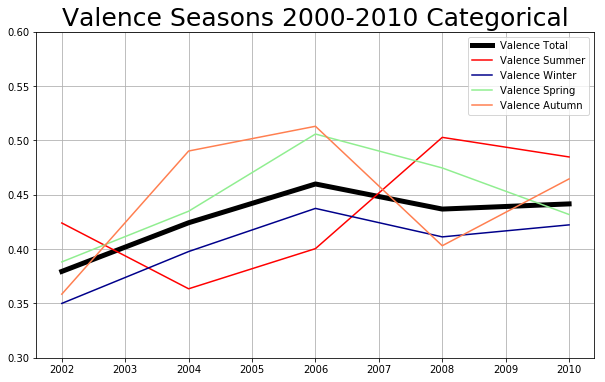

In [54]:
def valence_seasons_00_10_categorical():
    plt.grid()
    plt.ylim(0.3, 0.6)
#     plt.yscale("log")
    sns.lineplot(data=tracks_albums_total_2000_mean_valence["valence"], 
                 color="black", label="Valence Total", linewidth=5,)
    sns.lineplot(data=tracks_albums_summer_2000_year_mean_valence["valence"], 
                 color="red", label="Valence Summer")
    sns.lineplot(data=tracks_albums_winter_2000_year_mean_valence["valence"],
                 color="darkblue", label="Valence Winter")
    sns.lineplot(data=tracks_albums_spring_2000_year_mean_valence["valence"], 
                 color="lightgreen", label="Valence Spring")
    return sns.lineplot(data=tracks_albums_autumn_2000_year_mean_valence["valence"], 
                        color="coral", label="Valence Autumn")

std_plot(valence_seasons_00_10_categorical, title='Valence Seasons 2000-2010 Categorical')
    

In the previous plot we can observe that the valence of the tracks increased from the 2002 until 2006, then it had a small decrease until 2008 and since then has remained stable.

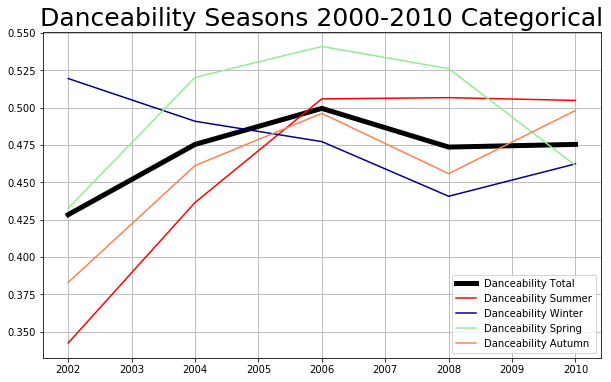

In [55]:
#summer
tracks_albums_summer_2000_year_mean = tracks_albums_summer_2000_year.groupby('categorical_year').mean()
tracks_albums_summer_2000_year_mean_dancebility = tracks_albums_summer_2000_year_mean[['danceability']]

#winter
tracks_albums_winter_2000_year_mean = tracks_albums_winter_2000_year.groupby('categorical_year').mean()
tracks_albums_winter_2000_year_mean_dancebility = tracks_albums_winter_2000_year_mean[['danceability']]

#spring
tracks_albums_spring_2000_year_mean = tracks_albums_spring_2000_year.groupby('categorical_year').mean()
tracks_albums_spring_2000_year_mean_dancebility = tracks_albums_spring_2000_year_mean[['danceability']]

#autumn
tracks_albums_autumn_2000_year_mean = tracks_albums_autumn_2000_year.groupby('categorical_year').mean()
tracks_albums_autumn_2000_year_mean_dancebility = tracks_albums_autumn_2000_year_mean[['danceability']]
#total
tracks_albums_total_2000_mean = tracks_albums_total_2000_year.groupby('categorical_year').mean()
tracks_albums_total_2000_mean_valence = tracks_albums_total_2000_mean[['danceability']]

def danceability_seasons_00_10_categorical():
    plt.grid()
    sns.lineplot(data=tracks_albums_total_2000_mean_valence["danceability"], 
                 color="black", label="Danceability Total", linewidth=5)
    sns.lineplot(data=tracks_albums_summer_2000_year_mean_dancebility["danceability"],
                 color="red", label="Danceability Summer")
    sns.lineplot(data=tracks_albums_winter_2000_year_mean_dancebility["danceability"], 
                 color="darkblue", label="Danceability Winter")
    sns.lineplot(data=tracks_albums_spring_2000_year_mean_dancebility["danceability"],
                 color="lightgreen", label="Danceability Spring")
    return sns.lineplot(data=tracks_albums_autumn_2000_year_mean_dancebility["danceability"],
                        color="coral", label="Danceability Autumn")

std_plot(danceability_seasons_00_10_categorical, title='Danceability Seasons 2000-2010 Categorical')


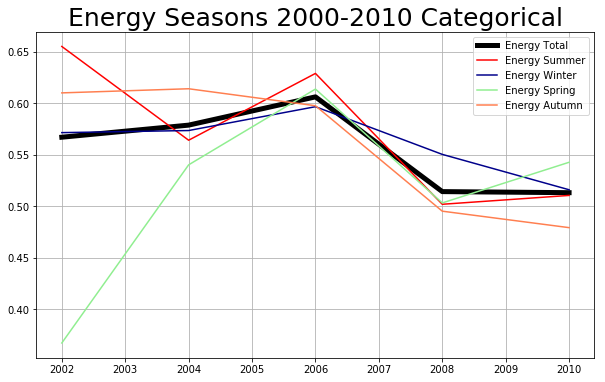

In [56]:
#summer
tracks_albums_summer_2000_year_mean = tracks_albums_summer_2000_year.groupby('categorical_year').mean()
tracks_albums_summer_2000_year_mean_energy = tracks_albums_summer_2000_year_mean[['energy']]

# winter
tracks_albums_winter_2000_year_mean = tracks_albums_winter_2000_year.groupby('categorical_year').mean()
tracks_albums_winter_2000_year_mean_energy = tracks_albums_winter_2000_year_mean[['energy']]

#spring
tracks_albums_spring_2000_year_mean = tracks_albums_spring_2000_year.groupby('categorical_year').mean()
tracks_albums_spring_2000_year_mean_energy = tracks_albums_spring_2000_year_mean[['energy']]

#autumn
tracks_albums_autumn_2000_year_mean = tracks_albums_autumn_2000_year.groupby('categorical_year').mean()
tracks_albums_autumn_2000_year_mean_energy = tracks_albums_autumn_2000_year_mean[['energy']]
#total
tracks_albums_total_2000_mean = tracks_albums_total_2000_year.groupby('categorical_year').mean()
tracks_albums_total_2000_mean_valence = tracks_albums_total_2000_mean[['energy']]

def energy_seasons_00_10_categorical():
    plt.grid()
    sns.lineplot(data=tracks_albums_total_2000_mean_valence["energy"], 
                 color="black", label="Energy Total", linewidth=5)
    sns.lineplot(data=tracks_albums_summer_2000_year_mean_energy["energy"],
                 color="red", label="Energy Summer")
    sns.lineplot(data=tracks_albums_winter_2000_year_mean_energy["energy"],
                 color="darkblue", label="Energy Winter")
    sns.lineplot(data=tracks_albums_spring_2000_year_mean_energy["energy"],
                 color="lightgreen", label="Energy Spring")
    return sns.lineplot(data=tracks_albums_autumn_2000_year_mean_energy["energy"], 
                        color="coral", label="Energy Autumn")

std_plot(energy_seasons_00_10_categorical, title='Energy Seasons 2000-2010 Categorical')


## Evolution of music 2010-2018 Valence/Energy/Danceability
##### With categorical value of 2 to reduce noise 

In [57]:
#summer
tracks_albums_summer_2010 = tracks_albums.loc[lambda tracks_albums: (tracks_albums.album_date_released.dt.month >5)\
                 & (tracks_albums.album_date_released.dt.month <9) \
                 & (tracks_albums.album_date_released.dt.year >2009)]
tracks_albums_summer_2010 = tracks_albums_summer_2010.copy()
tracks_albums_summer_2010['categorical_year'] = pd.cut(tracks_albums_summer_2010['album_date_released'].dt.year, \
                                                       [2010, 2012, 2014, 2016, 2018], \
                                                       labels=[2012, 2014, 2016, 2018])
tracks_albums_summer_2010_year = tracks_albums_summer_2010.groupby('categorical_year').mean()

#winter
tracks_albums_winter_2010 = tracks_albums.loc[lambda tracks_albums: ((tracks_albums.album_date_released.dt.month <3)\
                 | (tracks_albums.album_date_released.dt.month >11)) \
                 & (tracks_albums.album_date_released.dt.year >2009)]
tracks_albums_winter_2010 = tracks_albums_winter_2010.copy()
tracks_albums_winter_2010['categorical_year'] = pd.cut(tracks_albums_winter_2010['album_date_released'].dt.year, \
                                                       [2010, 2012, 2014, 2016, 2018], \
                                                       labels=[2012, 2014, 2016, 2018])
tracks_albums_winter_2010_year = tracks_albums_winter_2010.groupby('categorical_year').mean()

#spring
tracks_albums_spring_2010 = tracks_albums.loc[lambda tracks_albums: (tracks_albums.album_date_released.dt.month >2)\
                 & (tracks_albums.album_date_released.dt.month <6) \
                 & (tracks_albums.album_date_released.dt.year >2009)]
tracks_albums_spring_2010 = tracks_albums_spring_2010.copy()
tracks_albums_spring_2010['categorical_year'] = pd.cut(tracks_albums_spring_2010['album_date_released'].dt.year, \
                                                       [2010, 2012, 2014, 2016, 2018], \
                                                       labels=[2012, 2014, 2016, 2018])
tracks_albums_spring_2010_year = tracks_albums_spring_2010.groupby('categorical_year').mean()

#autumn
tracks_albums_autumn_2010 = tracks_albums.loc[lambda tracks_albums: (tracks_albums.album_date_released.dt.month >8)\
                 & (tracks_albums.album_date_released.dt.month <12) \
                 & (tracks_albums.album_date_released.dt.year >2009)]
tracks_albums_autumn_2010 = tracks_albums_autumn_2010.copy()
tracks_albums_autumn_2010['categorical_year'] = pd.cut(tracks_albums_autumn_2010['album_date_released'].dt.year, \
                                                       [2010, 2012, 2014, 2016, 2018], \
                                                       labels=[2012, 2014, 2016, 2018])
tracks_albums_autumn_2010_year = tracks_albums_autumn_2010.groupby('categorical_year').mean()
#total
tracks_albums_total_2010 = tracks_albums.loc[lambda tracks_albums:(tracks_albums.album_date_released.dt.year >2009)\
                 & (tracks_albums.album_date_released.dt.year <2019)]
tracks_albums_total_2010 = tracks_albums_total_2010.copy()
tracks_albums_total_2010['categorical_year'] = pd.cut(tracks_albums_total_2010['album_date_released'].dt.year, \
                                                       [2010, 2012, 2014, 2016, 2018], \
                                                       labels=[2012, 2014, 2016, 2018])
tracks_albums_total_2010_year = tracks_albums_total_2010.groupby('categorical_year').mean()


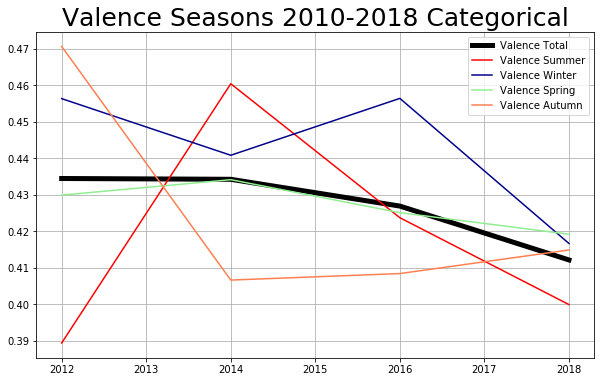

In [58]:
#summer
tracks_albums_summer_2010_year_mean = tracks_albums_summer_2010_year.groupby('categorical_year').mean()
tracks_albums_summer_2010_year_mean_valence = tracks_albums_summer_2010_year_mean[['valence']]

#winter
tracks_albums_winter_2010_year_mean = tracks_albums_winter_2010_year.groupby('categorical_year').mean()
tracks_albums_winter_2010_year_mean_valence = tracks_albums_winter_2010_year_mean[['valence']]

#spring
tracks_albums_spring_2010_year_mean = tracks_albums_spring_2010_year.groupby('categorical_year').mean()
tracks_albums_spring_2010_year_mean_valence = tracks_albums_spring_2010_year_mean[['valence']]

#autumn
tracks_albums_autumn_2010_year_mean = tracks_albums_autumn_2010_year.groupby('categorical_year').mean()
tracks_albums_autumn_2010_year_mean_valence = tracks_albums_autumn_2010_year_mean[['valence']]

#total
tracks_albums_total_2010_mean = tracks_albums_total_2010_year.groupby('categorical_year').mean()
tracks_albums_total_2010_mean_valence = tracks_albums_total_2010_mean[['valence']]

def valence_seasons_10_18_categorical():
    plt.grid()
    sns.lineplot(data=tracks_albums_total_2010_mean_valence["valence"], 
                 color="black", label="Valence Total", linewidth=5)
    sns.lineplot(data=tracks_albums_summer_2010_year_mean_valence["valence"],
                 color="red", label="Valence Summer")
    sns.lineplot(data=tracks_albums_winter_2010_year_mean_valence["valence"], 
                 color="darkblue", label="Valence Winter")
    sns.lineplot(data=tracks_albums_spring_2010_year_mean_valence["valence"], 
                 color="lightgreen", label="Valence Spring")
    return sns.lineplot(data=tracks_albums_autumn_2010_year_mean_valence["valence"], 
                        color="coral", label="Valence Autumn")

std_plot(valence_seasons_10_18_categorical, title='Valence Seasons 2010-2018 Categorical')


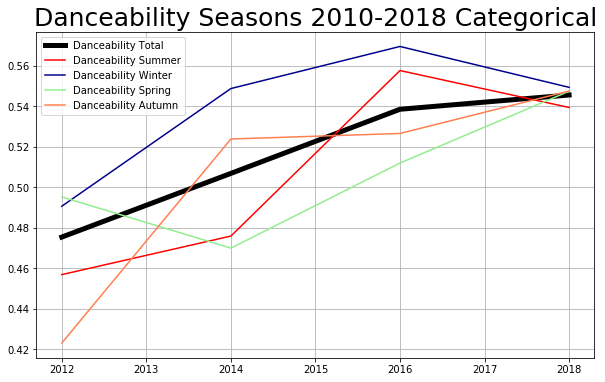

In [59]:
#summer
tracks_albums_summer_2010_year_mean = tracks_albums_summer_2010_year.groupby('categorical_year').mean()
tracks_albums_summer_2010_year_mean_danceability= tracks_albums_summer_2010_year_mean[['danceability']]

#winter
tracks_albums_winter_2010_year_mean = tracks_albums_winter_2010_year.groupby('categorical_year').mean()
tracks_albums_winter_2010_year_mean_danceability = tracks_albums_winter_2010_year_mean[['danceability']]

#spring
tracks_albums_spring_2010_year_mean = tracks_albums_spring_2010_year.groupby('categorical_year').mean()
tracks_albums_spring_2010_year_mean_danceability = tracks_albums_spring_2010_year_mean[['danceability']]

#autumn
tracks_albums_autumn_2010_year_mean = tracks_albums_autumn_2010_year.groupby('categorical_year').mean()
tracks_albums_autumn_2010_year_mean_danceability = tracks_albums_autumn_2010_year_mean[['danceability']]

#total
tracks_albums_total_2010_mean = tracks_albums_total_2010_year.groupby('categorical_year').mean()
tracks_albums_total_2010_mean_valence = tracks_albums_total_2010_mean[['danceability']]

def danceability_seasons_10_18_categorical():
    plt.grid()
    sns.lineplot(data=tracks_albums_total_2010_mean_valence["danceability"], 
                 color="black", label="Danceability Total", linewidth=5)
    sns.lineplot(data=tracks_albums_summer_2010_year_mean_danceability["danceability"],
                 color="red", label="Danceability Summer")
    sns.lineplot(data=tracks_albums_winter_2010_year_mean_danceability["danceability"],
                 color="darkblue", label="Danceability Winter")
    sns.lineplot(data=tracks_albums_spring_2010_year_mean_danceability["danceability"],
                 color="lightgreen", label="Danceability Spring")
    return sns.lineplot(data=tracks_albums_autumn_2010_year_mean_danceability["danceability"],
                        color="coral", label="Danceability Autumn")

std_plot(danceability_seasons_10_18_categorical, title='Danceability Seasons 2010-2018 Categorical')


The previous plot shows the increase of the evolution of the danceability of the tracks, as we can observe there is a clear increase of the danceability, the season where the danceability is higher is winter, but this may be somewhat missleading because winter for the north hemisphere is summer on the south hemisphere, and the gender with the highest danceability is international, where we can have salsa, latin, etc. Coincidence?

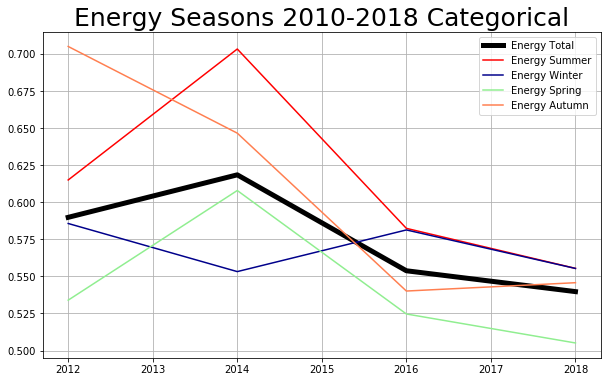

In [60]:
#summer
tracks_albums_summer_2010_year_mean = tracks_albums_summer_2010_year.groupby('categorical_year').mean()
tracks_albums_summer_2010_year_mean_energy = tracks_albums_summer_2010_year_mean[['energy']]

#winter
tracks_albums_winter_2010_year_mean = tracks_albums_winter_2010_year.groupby('categorical_year').mean()
tracks_albums_winter_2010_year_mean_energy = tracks_albums_winter_2010_year_mean[['energy']]

#spring
tracks_albums_spring_2010_year_mean = tracks_albums_spring_2010_year.groupby('categorical_year').mean()
tracks_albums_spring_2010_year_mean_energy = tracks_albums_spring_2010_year_mean[['energy']]

#autumn
tracks_albums_autumn_2010_year_mean = tracks_albums_autumn_2010_year.groupby('categorical_year').mean()
tracks_albums_autumn_2010_year_mean_energy = tracks_albums_autumn_2010_year_mean[['energy']]

#total
tracks_albums_total_2010_mean = tracks_albums_total_2010_year.groupby('categorical_year').mean()
tracks_albums_total_2010_mean_valence = tracks_albums_total_2010_mean[['energy']]

def energy_seasons_10_18_categorical():
    plt.grid()
    sns.lineplot(data=tracks_albums_total_2010_mean_valence["energy"], 
                 color="black", label="Energy Total", linewidth=5)
    sns.lineplot(data=tracks_albums_summer_2010_year_mean_energy["energy"], 
                 color="red", label="Energy Summer")
    sns.lineplot(data=tracks_albums_winter_2010_year_mean_energy["energy"],
                 color="darkblue", label="Energy Winter")
    sns.lineplot(data=tracks_albums_spring_2010_year_mean_energy["energy"],
                 color="lightgreen", label="Energy Spring")
    return sns.lineplot(data=tracks_albums_autumn_2010_year_mean_energy["energy"],
                        color="coral", label="Energy Autumn")

std_plot(energy_seasons_10_18_categorical, title='Energy Seasons 2010-2018 Categorical')


In [61]:
# alls = tracks_df.merge(track_genre_rel_df).merge(genres_df) \
# .merge(albums_df).merge(artists_df)
# # alls = alls['album_date_released'].dt.year
# alls[alls['album_date_released'].dt.year > 2013]
# genres = alls.groupby('genre_parent').mean().sort_values(by='song_hotness',
#                                                   ascending=False).head(10)
# genres = genres.reset_index()[['genre_id', 'genre_parent']]

# a = tracks_df.merge(track_genre_rel_df).merge(genres_df).merge(genres, right_on='genre_parent', left_on='genre_parent') \
#         .merge(albums_df).merge(artists_df)
# b = a.sort_values(by='song_hotness', ascending=False)
# c = b.groupby(['genre_parent', b.album_date_released.dt.year, 'artist_name']).mean()
# c.dropna(subset=['song_hotness'])
# c.sort_values(by='song_hotness', ascending=False, inplace=True)
# c.head(200)
# # c.danceability
# # tracks_albums_winter_2010 = tracks_albums.loc[lambda tracks_albums: ((tracks_albums.album_date_released.dt.month <3)\
# #                  | (tracks_albums.album_date_released.dt.month >11)) \
# #                  & (tracks_albums.album_date_released.dt.year >2009)]
# # test = c.loc[lambda c:(c.album_date_released>2016)]
# # test
# # c.to_csv('test.csv', encoding='utf-8')